# Beskrivelse
Her gives det det samme kode som i Eksemple_CNN.ipynb. Modelen der kunne når et test accuracy på 95-96%. Her skal vi undersøg om vi kan lave modellen bedre, eller dårligere, og se hvordan at ændre de forskellige parametere har effekt på resultatet. Først starter vi med at kopiere hjælpe kode filerne:

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    !cp -r "/content/drive/MyDrive/Colab Notebooks/ML-Camp-2025/ConvNets/utils" .
except ImportError:
    print("Not in colab. Skipping copying the utilities files.")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Vigtigt
Denne script gemmer modeller, men de bliver ikke gemt i din drev. Du kan bruge den nedenstående kodeblok for at kopiere modellene til din drev. Bare sørg for at du har mindst 250mb tilbage i din drev.

In [ ]:
# Bruge pathlib til at lave en folder til modellene hvis den ikke allerede eksistere
from pathlib import Path
Path("/content/drive/MyDrive/Colab Notebooks/ML-Camp-2025/ConvNets/saved_models/").mkdir(parents=True, exist_ok=True)
# Kopiere modellene til drevet
!cp saved_models/* "/content/drive/MyDrive/Colab Notebooks/ML-Camp-2025/ConvNets/saved_models/"

Nu kan vi importerer pakker og overfører datasætet.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from utils.train import train, plot_training_logs
from utils.test import test
from utils.options import Hyperparameters, name_generator

# Tjekke om der er GPU ellers bruge CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Denne transform funktion gives til datasættet for at billederne kommer ud i den rigtig format, som er matricer med værdier mellem 0 og 1.
# Vi normalisere pixlerne fra [0, 255] til [0, 1] fordi mest ML algoritmer er bygget til at arbejde bedst med normaliseret data.
def image_transform(img):
    return torchvision.transforms.ToTensor()(img)#.unsqueeze(0)

# Overfører CIFAR10 træning og test datasætene fra pytorch
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=image_transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=image_transform)

# Splitter træning sætet til en træning og validering sæt.
# val_set_ratio bestemmer hvor meget af sættet bliver brugt til validering.
val_set_ratio = 0.1
train_set, val_set = random_split(train_set, [int(len(train_set)*(1-val_set_ratio)), int(len(train_set)*val_set_ratio)])

# Tjekker størrelsen af billederne og hvor mange klasser der er
print("Images shape:", train_set[0][0].shape)
print("Number of classes:", len(np.unique(test_set.targets)))

# Model / data parameter
num_classes = 10
input_shape = (1, 28, 28)

# Laver dataloadere der samler vores data i batches og shuffler dem hvis vi vil gerne
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Images shape: torch.Size([1, 28, 28])
Number of classes: 10


Køre den initial model igen så du kan sammenlign med den senere:

  5%|▌         | 1/20 [00:13<04:07, 13.02s/it, Train_loss=0.817, Val_loss=0.271, Train_acc=0.756, Val_acc=0.916, Time_Taken=12.938s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9162234042553191 i 'saved_models/base_model_best.pt'


 10%|█         | 2/20 [00:23<03:24, 11.36s/it, Train_loss=0.346, Val_loss=0.192, Train_acc=0.894, Val_acc=0.944, Time_Taken=10.143s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9443151595744681 i 'saved_models/base_model_best.pt'


 15%|█▌        | 3/20 [00:33<03:04, 10.83s/it, Train_loss=0.286, Val_loss=0.160, Train_acc=0.914, Val_acc=0.955, Time_Taken=10.137s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9553413124794655 i 'saved_models/base_model_best.pt'


 20%|██        | 4/20 [00:43<02:46, 10.41s/it, Train_loss=0.253, Val_loss=0.141, Train_acc=0.923, Val_acc=0.959, Time_Taken=9.688s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.959053634963137 i 'saved_models/base_model_best.pt'


 25%|██▌       | 5/20 [00:53<02:34, 10.27s/it, Train_loss=0.233, Val_loss=0.127, Train_acc=0.929, Val_acc=0.965, Time_Taken=9.967s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9654809401390401 i 'saved_models/base_model_best.pt'


 30%|███       | 6/20 [01:03<02:23, 10.26s/it, Train_loss=0.218, Val_loss=0.123, Train_acc=0.934, Val_acc=0.963, Time_Taken=10.208s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'


 35%|███▌      | 7/20 [01:14<02:16, 10.51s/it, Train_loss=0.208, Val_loss=0.118, Train_acc=0.937, Val_acc=0.964, Time_Taken=10.996s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'


 40%|████      | 8/20 [01:24<02:04, 10.39s/it, Train_loss=0.198, Val_loss=0.107, Train_acc=0.939, Val_acc=0.969, Time_Taken=10.038s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9685837765957447 i 'saved_models/base_model_best.pt'


 45%|████▌     | 9/20 [01:34<01:51, 10.11s/it, Train_loss=0.187, Val_loss=0.103, Train_acc=0.943, Val_acc=0.969, Time_Taken=9.439s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9693594860269669 i 'saved_models/base_model_best.pt'


 50%|█████     | 10/20 [01:45<01:43, 10.37s/it, Train_loss=0.180, Val_loss=0.105, Train_acc=0.946, Val_acc=0.970, Time_Taken=10.900s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9701351954581889 i 'saved_models/base_model_best.pt'


 55%|█████▌    | 11/20 [01:55<01:32, 10.32s/it, Train_loss=0.170, Val_loss=0.097, Train_acc=0.948, Val_acc=0.972, Time_Taken=10.137s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9720190604950519 i 'saved_models/base_model_best.pt'


 60%|██████    | 12/20 [02:05<01:22, 10.31s/it, Train_loss=0.166, Val_loss=0.095, Train_acc=0.949, Val_acc=0.972, Time_Taken=10.234s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9722960997135082 i 'saved_models/base_model_best.pt'


 65%|██████▌   | 13/20 [02:15<01:11, 10.21s/it, Train_loss=0.154, Val_loss=0.086, Train_acc=0.953, Val_acc=0.974, Time_Taken=9.910s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9744570039688273 i 'saved_models/base_model_best.pt'


 70%|███████   | 14/20 [02:25<01:00, 10.13s/it, Train_loss=0.150, Val_loss=0.087, Train_acc=0.955, Val_acc=0.973, Time_Taken=9.883s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'


 75%|███████▌  | 15/20 [02:36<00:51, 10.28s/it, Train_loss=0.142, Val_loss=0.080, Train_acc=0.957, Val_acc=0.976, Time_Taken=10.598s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.976063829787234 i 'saved_models/base_model_best.pt'


 80%|████████  | 16/20 [02:46<00:41, 10.33s/it, Train_loss=0.134, Val_loss=0.078, Train_acc=0.959, Val_acc=0.977, Time_Taken=10.389s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.977061170212766 i 'saved_models/base_model_best.pt'


 85%|████████▌ | 17/20 [02:56<00:30, 10.33s/it, Train_loss=0.127, Val_loss=0.075, Train_acc=0.961, Val_acc=0.978, Time_Taken=10.258s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9781693264524988 i 'saved_models/base_model_best.pt'


 90%|█████████ | 18/20 [03:06<00:20, 10.11s/it, Train_loss=0.121, Val_loss=0.072, Train_acc=0.962, Val_acc=0.980, Time_Taken=9.546s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9798315604950519 i 'saved_models/base_model_best.pt'


 95%|█████████▌| 19/20 [03:16<00:10, 10.17s/it, Train_loss=0.116, Val_loss=0.070, Train_acc=0.965, Val_acc=0.980, Time_Taken=10.254s]

Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9800531914893617 i 'saved_models/base_model_best.pt'


100%|██████████| 20/20 [03:27<00:00, 10.35s/it, Train_loss=0.113, Val_loss=0.065, Train_acc=0.966, Val_acc=0.981, Time_Taken=10.196s]


Gemt modellen fra sidste checkpoint i 'saved_models/base_model.pt'
Gemt modellen med bedste accuracy 0.9811059401390401 i 'saved_models/base_model_best.pt'
Træning er færdigt. Træning tog 205.85797146899995s og average epoch tid var 10.292898573449998


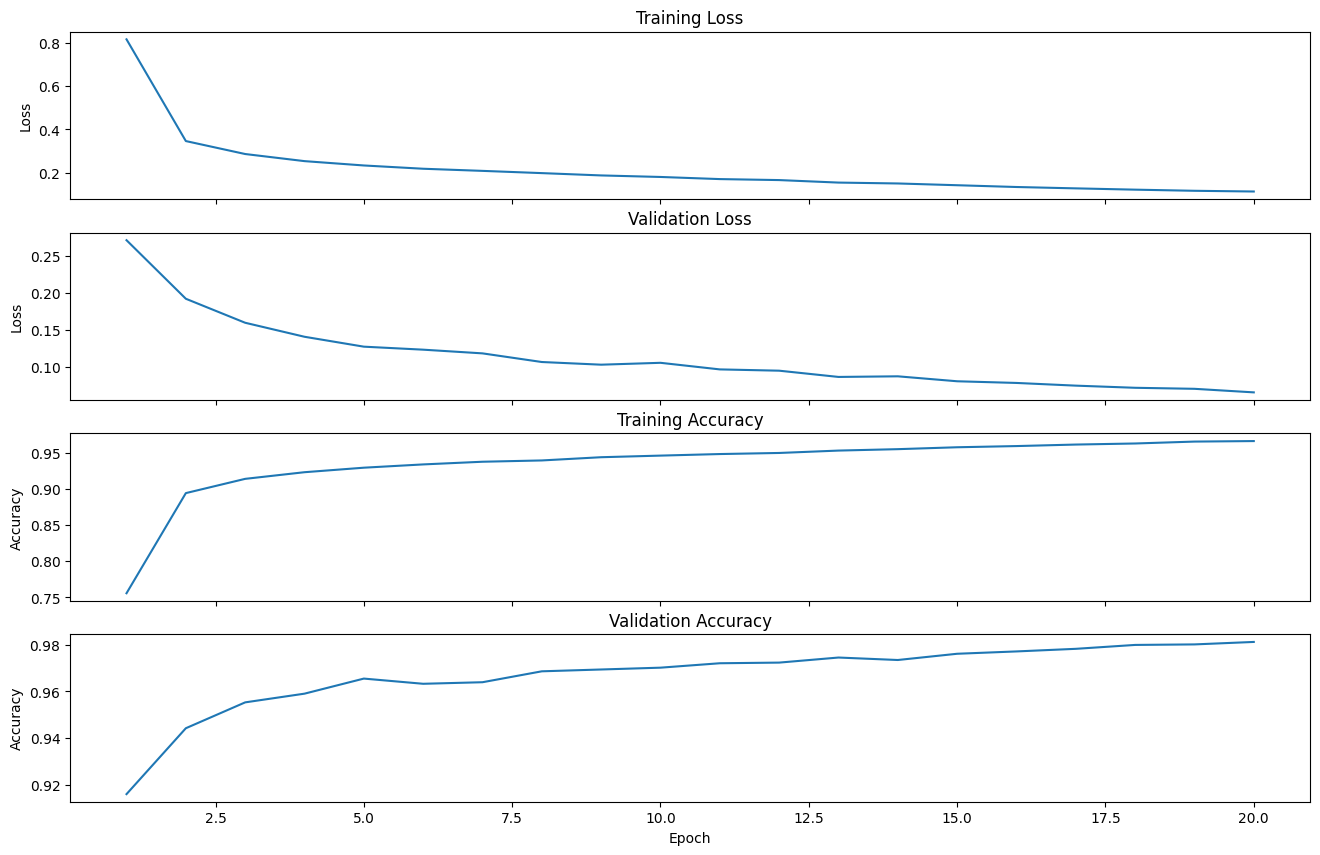

In [3]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 12, 12)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "base_model",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

## Opgaver: Undersøg forskellige modeller
Igennem disse opgaver vil du finde instruktioner i øverest, og så vil du finde steder hvor der står "fix" eller "NOTE:, som kan hjælpe dig med at kigge efter hvor du skal ændre i koden.

### Convolution lagene
Nu skal du ændre parameter i modellen og se hvis de har en effekt på performance (val_accuracy) og træning hastighed (ms/step). Første prøv at ændre antal af convolution lag. Den første convolution lag med dens relu aktivering er blevet fjernet. Fix koden og se hvad der sker med validering accuracy. **Husk at opdatere input størrelsen for conv2 og kerne størrelse + stride for conv3**:

  5%|▌         | 1/20 [00:10<03:14, 10.22s/it, Train_loss=0.780, Val_loss=0.336, Train_acc=0.777, Val_acc=0.903, Time_Taken=10.159s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9029809401390401 i 'saved_models/no_conv1_best.pt'


 10%|█         | 2/20 [00:20<03:00, 10.03s/it, Train_loss=0.396, Val_loss=0.252, Train_acc=0.885, Val_acc=0.924, Time_Taken=9.808s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9237034574468085 i 'saved_models/no_conv1_best.pt'


 15%|█▌        | 3/20 [00:29<02:48,  9.91s/it, Train_loss=0.329, Val_loss=0.218, Train_acc=0.904, Val_acc=0.935, Time_Taken=9.723s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9347850179418604 i 'saved_models/no_conv1_best.pt'


 20%|██        | 4/20 [00:41<02:46, 10.40s/it, Train_loss=0.288, Val_loss=0.188, Train_acc=0.915, Val_acc=0.942, Time_Taken=11.095s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9424312945376051 i 'saved_models/no_conv1_best.pt'


 25%|██▌       | 5/20 [00:51<02:34, 10.31s/it, Train_loss=0.267, Val_loss=0.168, Train_acc=0.923, Val_acc=0.951, Time_Taken=10.098s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.951241134963137 i 'saved_models/no_conv1_best.pt'


 30%|███       | 6/20 [01:01<02:22, 10.18s/it, Train_loss=0.246, Val_loss=0.157, Train_acc=0.928, Val_acc=0.953, Time_Taken=9.851s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9532912234042553 i 'saved_models/no_conv1_best.pt'


 35%|███▌      | 7/20 [01:10<02:10, 10.03s/it, Train_loss=0.225, Val_loss=0.141, Train_acc=0.934, Val_acc=0.958, Time_Taken=9.657s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9578900711333498 i 'saved_models/no_conv1_best.pt'


 40%|████      | 8/20 [01:21<02:01, 10.09s/it, Train_loss=0.214, Val_loss=0.133, Train_acc=0.938, Val_acc=0.963, Time_Taken=10.180s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9625443264524988 i 'saved_models/no_conv1_best.pt'


 45%|████▌     | 9/20 [01:31<01:51, 10.12s/it, Train_loss=0.204, Val_loss=0.125, Train_acc=0.940, Val_acc=0.965, Time_Taken=10.116s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.964594414893617 i 'saved_models/no_conv1_best.pt'


 50%|█████     | 10/20 [01:41<01:41, 10.12s/it, Train_loss=0.196, Val_loss=0.120, Train_acc=0.942, Val_acc=0.967, Time_Taken=10.025s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9670323583673923 i 'saved_models/no_conv1_best.pt'


 55%|█████▌    | 11/20 [01:50<01:29,  9.94s/it, Train_loss=0.186, Val_loss=0.113, Train_acc=0.946, Val_acc=0.969, Time_Taken=9.469s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.969248670212766 i 'saved_models/no_conv1_best.pt'


 60%|██████    | 12/20 [02:01<01:20, 10.03s/it, Train_loss=0.177, Val_loss=0.107, Train_acc=0.948, Val_acc=0.970, Time_Taken=10.168s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9704676422666996 i 'saved_models/no_conv1_best.pt'


 65%|██████▌   | 13/20 [02:11<01:10, 10.08s/it, Train_loss=0.167, Val_loss=0.104, Train_acc=0.951, Val_acc=0.972, Time_Taken=10.160s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.971520390282286 i 'saved_models/no_conv1_best.pt'


 70%|███████   | 14/20 [02:21<01:00, 10.14s/it, Train_loss=0.161, Val_loss=0.097, Train_acc=0.953, Val_acc=0.973, Time_Taken=10.218s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9726285465220188 i 'saved_models/no_conv1_best.pt'


 75%|███████▌  | 15/20 [02:31<00:49,  9.98s/it, Train_loss=0.155, Val_loss=0.095, Train_acc=0.952, Val_acc=0.972, Time_Taken=9.545s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'


 80%|████████  | 16/20 [02:41<00:40, 10.03s/it, Train_loss=0.150, Val_loss=0.092, Train_acc=0.955, Val_acc=0.974, Time_Taken=10.090s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.974179964750371 i 'saved_models/no_conv1_best.pt'


 85%|████████▌ | 17/20 [02:51<00:30, 10.07s/it, Train_loss=0.146, Val_loss=0.090, Train_acc=0.957, Val_acc=0.975, Time_Taken=10.093s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9750664893617021 i 'saved_models/no_conv1_best.pt'


 90%|█████████ | 18/20 [03:01<00:20, 10.09s/it, Train_loss=0.141, Val_loss=0.090, Train_acc=0.958, Val_acc=0.975, Time_Taken=10.105s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'


 95%|█████████▌| 19/20 [03:11<00:09, 10.00s/it, Train_loss=0.135, Val_loss=0.085, Train_acc=0.960, Val_acc=0.976, Time_Taken=9.707s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9758421987929242 i 'saved_models/no_conv1_best.pt'


100%|██████████| 20/20 [03:21<00:00, 10.07s/it, Train_loss=0.131, Val_loss=0.084, Train_acc=0.961, Val_acc=0.977, Time_Taken=9.832s]


Gemt modellen fra sidste checkpoint i 'saved_models/no_conv1.pt'
Gemt modellen med bedste accuracy 0.9765070924099456 i 'saved_models/no_conv1_best.pt'
Træning er færdigt. Træning tog 200.10003586099992s og average epoch tid var 10.005001793049995


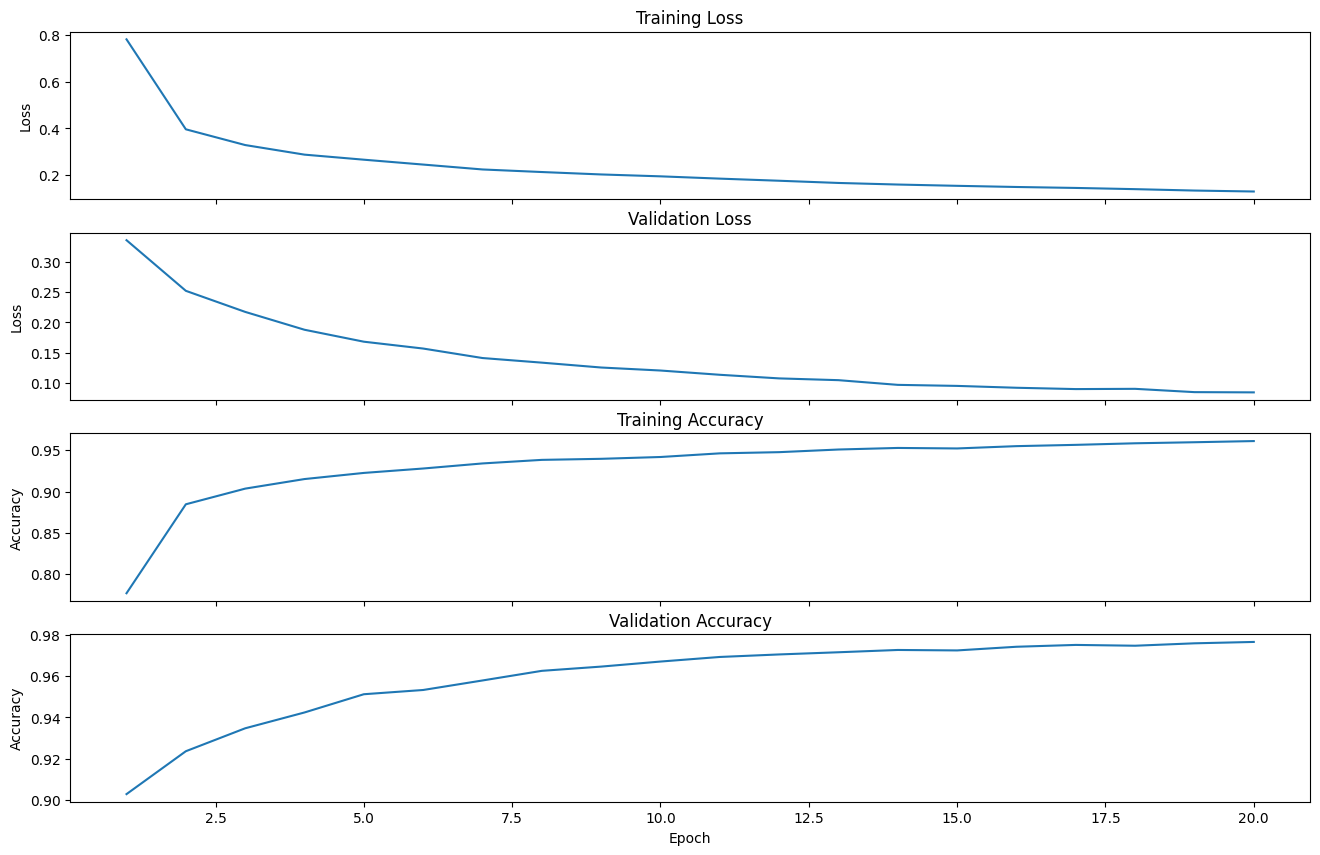

In [4]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        #self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(input_channels, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 13, 13)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        #x = self.conv1(x)
        #x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "no_conv1",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Nu er den anden convolution lag fjernet istedet med dens relu aktivering. **Husk at opdatere kerne størrelse + stride for conv3**:

  5%|▌         | 1/20 [00:09<03:03,  9.63s/it, Train_loss=0.996, Val_loss=0.376, Train_acc=0.720, Val_acc=0.893, Time_Taken=9.587s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.8929521276595744 i 'saved_models/no_conv2_best.pt'


 10%|█         | 2/20 [00:18<02:50,  9.48s/it, Train_loss=0.438, Val_loss=0.277, Train_acc=0.868, Val_acc=0.917, Time_Taken=9.296s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9167220744680851 i 'saved_models/no_conv2_best.pt'


 15%|█▌        | 3/20 [00:28<02:38,  9.29s/it, Train_loss=0.361, Val_loss=0.230, Train_acc=0.892, Val_acc=0.930, Time_Taken=9.033s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9302969860269669 i 'saved_models/no_conv2_best.pt'


 20%|██        | 4/20 [00:37<02:30,  9.39s/it, Train_loss=0.316, Val_loss=0.200, Train_acc=0.906, Val_acc=0.942, Time_Taken=9.502s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9416001775163285 i 'saved_models/no_conv2_best.pt'


 25%|██▌       | 5/20 [00:47<02:21,  9.46s/it, Train_loss=0.287, Val_loss=0.176, Train_acc=0.915, Val_acc=0.948, Time_Taken=9.526s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.94758422006952 i 'saved_models/no_conv2_best.pt'


 30%|███       | 6/20 [00:55<02:09,  9.23s/it, Train_loss=0.263, Val_loss=0.159, Train_acc=0.923, Val_acc=0.953, Time_Taken=8.754s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9530695924099456 i 'saved_models/no_conv2_best.pt'


 35%|███▌      | 7/20 [01:05<02:01,  9.33s/it, Train_loss=0.242, Val_loss=0.149, Train_acc=0.928, Val_acc=0.954, Time_Taken=9.496s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9540669328354775 i 'saved_models/no_conv2_best.pt'


 40%|████      | 8/20 [01:15<01:52,  9.40s/it, Train_loss=0.230, Val_loss=0.136, Train_acc=0.931, Val_acc=0.959, Time_Taken=9.507s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9591090425531915 i 'saved_models/no_conv2_best.pt'


 45%|████▌     | 9/20 [01:24<01:43,  9.37s/it, Train_loss=0.215, Val_loss=0.130, Train_acc=0.936, Val_acc=0.964, Time_Taken=9.246s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9639295212765957 i 'saved_models/no_conv2_best.pt'


 50%|█████     | 10/20 [01:33<01:32,  9.27s/it, Train_loss=0.204, Val_loss=0.120, Train_acc=0.938, Val_acc=0.964, Time_Taken=8.987s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9644281914893617 i 'saved_models/no_conv2_best.pt'


 55%|█████▌    | 11/20 [01:42<01:24,  9.35s/it, Train_loss=0.196, Val_loss=0.114, Train_acc=0.942, Val_acc=0.967, Time_Taken=9.495s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9666445039688273 i 'saved_models/no_conv2_best.pt'


 60%|██████    | 12/20 [01:52<01:15,  9.44s/it, Train_loss=0.189, Val_loss=0.110, Train_acc=0.943, Val_acc=0.970, Time_Taken=9.592s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9696919328354775 i 'saved_models/no_conv2_best.pt'


 65%|██████▌   | 13/20 [02:01<01:04,  9.21s/it, Train_loss=0.181, Val_loss=0.105, Train_acc=0.946, Val_acc=0.970, Time_Taken=8.640s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9700797872340425 i 'saved_models/no_conv2_best.pt'


 70%|███████   | 14/20 [02:10<00:55,  9.33s/it, Train_loss=0.177, Val_loss=0.102, Train_acc=0.947, Val_acc=0.972, Time_Taken=9.563s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9722406914893617 i 'saved_models/no_conv2_best.pt'


 75%|███████▌  | 15/20 [02:20<00:46,  9.40s/it, Train_loss=0.172, Val_loss=0.097, Train_acc=0.949, Val_acc=0.973, Time_Taken=9.519s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9730718085106383 i 'saved_models/no_conv2_best.pt'


 80%|████████  | 16/20 [02:29<00:37,  9.34s/it, Train_loss=0.168, Val_loss=0.096, Train_acc=0.950, Val_acc=0.973, Time_Taken=9.140s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9731826243248392 i 'saved_models/no_conv2_best.pt'


 85%|████████▌ | 17/20 [02:38<00:27,  9.26s/it, Train_loss=0.161, Val_loss=0.093, Train_acc=0.952, Val_acc=0.976, Time_Taken=9.037s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9757867912028698 i 'saved_models/no_conv2_best.pt'


 90%|█████████ | 18/20 [02:48<00:18,  9.33s/it, Train_loss=0.155, Val_loss=0.088, Train_acc=0.954, Val_acc=0.975, Time_Taken=9.467s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'


 95%|█████████▌| 19/20 [02:57<00:09,  9.42s/it, Train_loss=0.149, Val_loss=0.088, Train_acc=0.955, Val_acc=0.976, Time_Taken=9.559s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9758421987929242 i 'saved_models/no_conv2_best.pt'


100%|██████████| 20/20 [03:06<00:00,  9.33s/it, Train_loss=0.147, Val_loss=0.085, Train_acc=0.955, Val_acc=0.978, Time_Taken=8.716s]


Gemt modellen fra sidste checkpoint i 'saved_models/no_conv2.pt'
Gemt modellen med bedste accuracy 0.9775044328354775 i 'saved_models/no_conv2_best.pt'
Træning er færdigt. Træning tog 185.66162517799967s og average epoch tid var 9.283081258899983


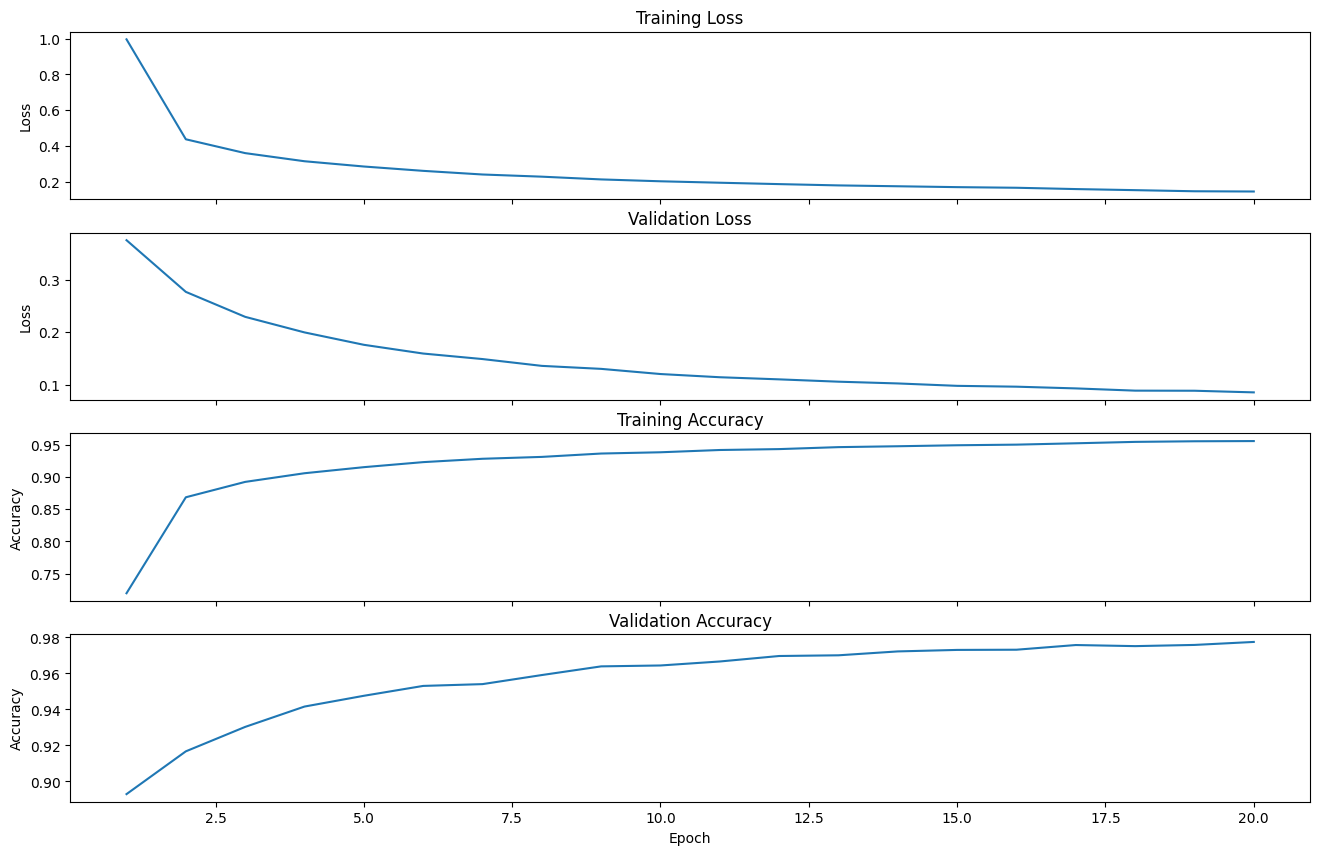

In [7]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        #self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(32, 128, 13, 13)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecture.to(device)ne fra model_architecture.py
model = Net(
    name = "no_conv2",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Hvad hvis du sætter et ekstra convolution lag. Initialisere en ny Conv2D og sæt den efter MaxPooling2D. Du kan selv vælge parametrene af laget, og **husk at opdaterer input størrelse + kerne størrelse + stride for conv3**:

  5%|▌         | 1/20 [00:14<04:31, 14.29s/it, Train_loss=1.166, Val_loss=0.316, Train_acc=0.628, Val_acc=0.901, Time_Taken=14.145s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9009308510638298 i 'saved_models/ekstra_conv_best.pt'


 10%|█         | 2/20 [00:23<03:18, 11.05s/it, Train_loss=0.343, Val_loss=0.189, Train_acc=0.895, Val_acc=0.943, Time_Taken=8.735s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9429853723404256 i 'saved_models/ekstra_conv_best.pt'


 15%|█▌        | 3/20 [00:32<02:52, 10.16s/it, Train_loss=0.245, Val_loss=0.142, Train_acc=0.926, Val_acc=0.953, Time_Taken=9.039s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9534574468085106 i 'saved_models/ekstra_conv_best.pt'


 20%|██        | 4/20 [00:40<02:33,  9.57s/it, Train_loss=0.192, Val_loss=0.127, Train_acc=0.942, Val_acc=0.961, Time_Taken=8.607s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9608820924099456 i 'saved_models/ekstra_conv_best.pt'


 25%|██▌       | 5/20 [00:49<02:18,  9.26s/it, Train_loss=0.161, Val_loss=0.100, Train_acc=0.952, Val_acc=0.968, Time_Taken=8.661s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9684175531914894 i 'saved_models/ekstra_conv_best.pt'


 30%|███       | 6/20 [00:58<02:08,  9.19s/it, Train_loss=0.141, Val_loss=0.086, Train_acc=0.957, Val_acc=0.973, Time_Taken=8.994s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9732380319148937 i 'saved_models/ekstra_conv_best.pt'


 35%|███▌      | 7/20 [01:07<01:59,  9.21s/it, Train_loss=0.123, Val_loss=0.083, Train_acc=0.964, Val_acc=0.974, Time_Taken=9.171s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9740137413461157 i 'saved_models/ekstra_conv_best.pt'


 40%|████      | 8/20 [01:16<01:48,  9.00s/it, Train_loss=0.112, Val_loss=0.072, Train_acc=0.967, Val_acc=0.979, Time_Taken=8.507s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9788896276595744 i 'saved_models/ekstra_conv_best.pt'


 45%|████▌     | 9/20 [01:25<01:39,  9.01s/it, Train_loss=0.104, Val_loss=0.072, Train_acc=0.968, Val_acc=0.978, Time_Taken=8.988s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'


 50%|█████     | 10/20 [01:34<01:29,  8.94s/it, Train_loss=0.096, Val_loss=0.071, Train_acc=0.972, Val_acc=0.979, Time_Taken=8.728s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'


 55%|█████▌    | 11/20 [01:42<01:19,  8.81s/it, Train_loss=0.088, Val_loss=0.060, Train_acc=0.974, Val_acc=0.982, Time_Taken=8.468s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.982491134963137 i 'saved_models/ekstra_conv_best.pt'


 60%|██████    | 12/20 [01:51<01:11,  8.89s/it, Train_loss=0.082, Val_loss=0.063, Train_acc=0.975, Val_acc=0.980, Time_Taken=9.027s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'


 65%|██████▌   | 13/20 [02:00<01:02,  8.92s/it, Train_loss=0.080, Val_loss=0.056, Train_acc=0.976, Val_acc=0.984, Time_Taken=8.918s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9837101063829787 i 'saved_models/ekstra_conv_best.pt'


 70%|███████   | 14/20 [02:09<00:52,  8.76s/it, Train_loss=0.074, Val_loss=0.056, Train_acc=0.977, Val_acc=0.984, Time_Taken=8.334s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'


 75%|███████▌  | 15/20 [02:18<00:44,  8.85s/it, Train_loss=0.069, Val_loss=0.055, Train_acc=0.979, Val_acc=0.984, Time_Taken=9.023s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.984375 i 'saved_models/ekstra_conv_best.pt'


 80%|████████  | 16/20 [02:27<00:35,  8.92s/it, Train_loss=0.067, Val_loss=0.054, Train_acc=0.979, Val_acc=0.985, Time_Taken=9.035s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9853169328354775 i 'saved_models/ekstra_conv_best.pt'


 85%|████████▌ | 17/20 [02:35<00:26,  8.73s/it, Train_loss=0.061, Val_loss=0.052, Train_acc=0.981, Val_acc=0.986, Time_Taken=8.213s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9860372340425532 i 'saved_models/ekstra_conv_best.pt'


 90%|█████████ | 18/20 [02:44<00:17,  8.84s/it, Train_loss=0.062, Val_loss=0.055, Train_acc=0.981, Val_acc=0.985, Time_Taken=9.054s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'


 95%|█████████▌| 19/20 [02:53<00:08,  8.90s/it, Train_loss=0.059, Val_loss=0.051, Train_acc=0.981, Val_acc=0.984, Time_Taken=8.991s]

Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'


100%|██████████| 20/20 [03:02<00:00,  9.10s/it, Train_loss=0.054, Val_loss=0.049, Train_acc=0.983, Val_acc=0.987, Time_Taken=8.191s]


Gemt modellen fra sidste checkpoint i 'saved_models/ekstra_conv.pt'
Gemt modellen med bedste accuracy 0.9874224295007422 i 'saved_models/ekstra_conv_best.pt'
Træning er færdigt. Træning tog 180.8284213600009s og average epoch tid var 9.041421068000044


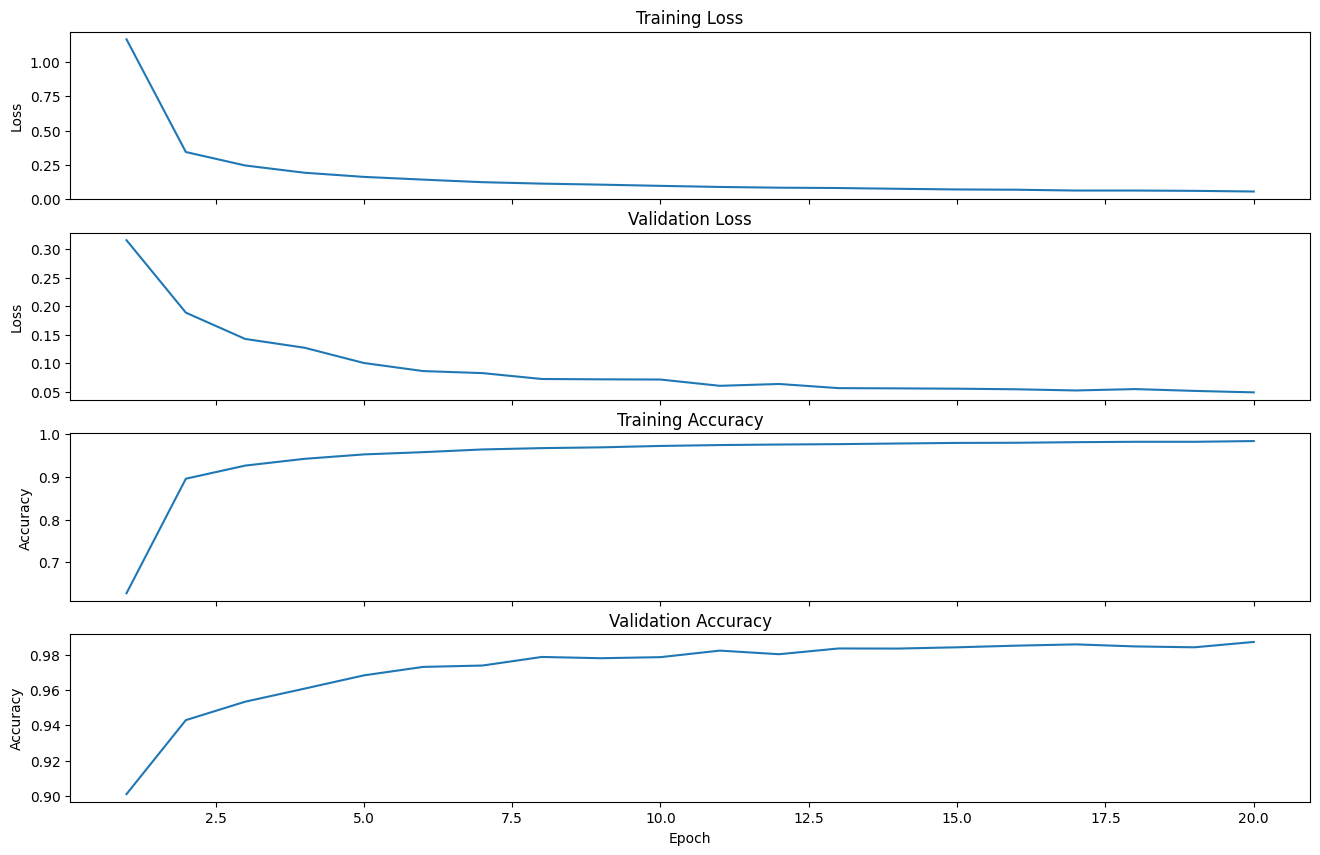

In [3]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # NOTE: Indsæt en ekstra convolution lag her. I kan kalde den self.conv_extra eller hvad som helst
        self.convExtra = nn.Conv2d(64, 96, 5, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(96, 128, 8, 8)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        # NOTE: Pass x igennem den ny convolution lag her
        x = self.convExtra(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "ekstra_conv",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Sammenlign hastighed og accuracy forskel mellem de tre sidste modeller og den basal model. Var de bedre eller dårligere? Hurtigere eller langsomere? Hvorfor tror du det?

### Max pooling lagene
Nu kigger vi på max pooling. Den ene max pooling lag er blevet fjernet fra modellen. Fix koden og se hvad der sker med hastighed og accuracy. **Husk at opdaterer kerne størrelse + stride for conv3**:

  5%|▌         | 1/20 [00:12<03:56, 12.42s/it, Train_loss=0.620, Val_loss=0.246, Train_acc=0.817, Val_acc=0.928, Time_Taken=12.289s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9276374115588817 i 'saved_models/no_max_pool_best.pt'


 10%|█         | 2/20 [00:24<03:41, 12.31s/it, Train_loss=0.297, Val_loss=0.187, Train_acc=0.911, Val_acc=0.946, Time_Taken=12.123s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9463098404255319 i 'saved_models/no_max_pool_best.pt'


 15%|█▌        | 3/20 [00:36<03:28, 12.26s/it, Train_loss=0.249, Val_loss=0.159, Train_acc=0.925, Val_acc=0.950, Time_Taken=12.095s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9500775711333498 i 'saved_models/no_max_pool_best.pt'


 20%|██        | 4/20 [00:49<03:15, 12.25s/it, Train_loss=0.219, Val_loss=0.151, Train_acc=0.934, Val_acc=0.956, Time_Taken=12.124s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9558399826922315 i 'saved_models/no_max_pool_best.pt'


 25%|██▌       | 5/20 [01:01<03:03, 12.25s/it, Train_loss=0.204, Val_loss=0.131, Train_acc=0.938, Val_acc=0.959, Time_Taken=12.153s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9591644507773379 i 'saved_models/no_max_pool_best.pt'


 30%|███       | 6/20 [01:13<02:51, 12.24s/it, Train_loss=0.191, Val_loss=0.128, Train_acc=0.943, Val_acc=0.961, Time_Taken=12.127s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9606604614156358 i 'saved_models/no_max_pool_best.pt'


 35%|███▌      | 7/20 [01:25<02:38, 12.22s/it, Train_loss=0.180, Val_loss=0.115, Train_acc=0.946, Val_acc=0.963, Time_Taken=12.076s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9632646276595744 i 'saved_models/no_max_pool_best.pt'


 40%|████      | 8/20 [01:37<02:26, 12.20s/it, Train_loss=0.174, Val_loss=0.110, Train_acc=0.949, Val_acc=0.966, Time_Taken=12.049s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9659242021276596 i 'saved_models/no_max_pool_best.pt'


 45%|████▌     | 9/20 [01:50<02:14, 12.19s/it, Train_loss=0.165, Val_loss=0.105, Train_acc=0.950, Val_acc=0.966, Time_Taken=12.055s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9664228723404256 i 'saved_models/no_max_pool_best.pt'


 50%|█████     | 10/20 [02:02<02:02, 12.21s/it, Train_loss=0.158, Val_loss=0.103, Train_acc=0.952, Val_acc=0.967, Time_Taken=12.158s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9673093975858486 i 'saved_models/no_max_pool_best.pt'


 55%|█████▌    | 11/20 [02:14<01:50, 12.27s/it, Train_loss=0.150, Val_loss=0.099, Train_acc=0.955, Val_acc=0.968, Time_Taken=12.250s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9684175531914894 i 'saved_models/no_max_pool_best.pt'


 60%|██████    | 12/20 [02:27<01:38, 12.28s/it, Train_loss=0.146, Val_loss=0.096, Train_acc=0.957, Val_acc=0.972, Time_Taken=12.133s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9715757978723404 i 'saved_models/no_max_pool_best.pt'


 65%|██████▌   | 13/20 [02:39<01:26, 12.31s/it, Train_loss=0.142, Val_loss=0.100, Train_acc=0.957, Val_acc=0.970, Time_Taken=12.302s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'


 70%|███████   | 14/20 [02:51<01:13, 12.29s/it, Train_loss=0.136, Val_loss=0.098, Train_acc=0.958, Val_acc=0.970, Time_Taken=12.140s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'


 75%|███████▌  | 15/20 [03:03<01:01, 12.23s/it, Train_loss=0.133, Val_loss=0.091, Train_acc=0.959, Val_acc=0.971, Time_Taken=12.031s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'


 80%|████████  | 16/20 [03:15<00:48, 12.22s/it, Train_loss=0.126, Val_loss=0.087, Train_acc=0.962, Val_acc=0.973, Time_Taken=12.091s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9730164009205838 i 'saved_models/no_max_pool_best.pt'


 85%|████████▌ | 17/20 [03:28<00:36, 12.20s/it, Train_loss=0.123, Val_loss=0.087, Train_acc=0.962, Val_acc=0.973, Time_Taken=12.083s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'


 90%|█████████ | 18/20 [03:40<00:24, 12.19s/it, Train_loss=0.117, Val_loss=0.083, Train_acc=0.964, Val_acc=0.973, Time_Taken=12.097s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'


 95%|█████████▌| 19/20 [03:52<00:12, 12.18s/it, Train_loss=0.113, Val_loss=0.085, Train_acc=0.965, Val_acc=0.974, Time_Taken=12.071s]

Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9737367021276596 i 'saved_models/no_max_pool_best.pt'


100%|██████████| 20/20 [04:04<00:00, 12.23s/it, Train_loss=0.110, Val_loss=0.080, Train_acc=0.966, Val_acc=0.975, Time_Taken=12.106s]


Gemt modellen fra sidste checkpoint i 'saved_models/no_max_pool.pt'
Gemt modellen med bedste accuracy 0.9753435285801583 i 'saved_models/no_max_pool_best.pt'
Træning er færdigt. Træning tog 242.55404973900022s og average epoch tid var 12.12770248695001


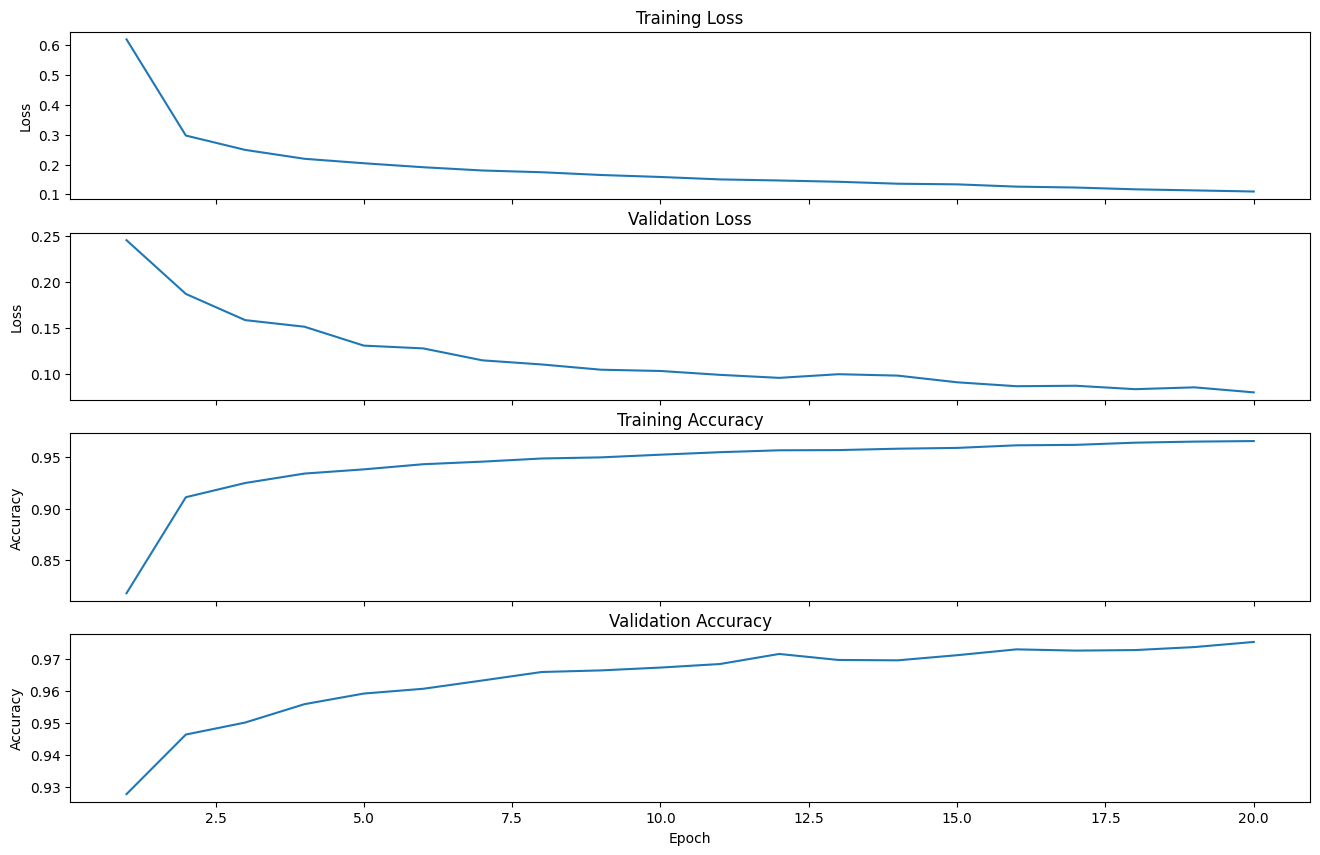

In [4]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 24, 24)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "no_max_pool",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Nu prøve at sætte et ekstre max pooling lag efter conv1 og dens aktivering. **Husk at opdaterer kerne størrelse + stride for conv3**:

  5%|▌         | 1/20 [00:09<02:59,  9.46s/it, Train_loss=1.404, Val_loss=0.439, Train_acc=0.547, Val_acc=0.874, Time_Taken=9.380s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.8740580677986145 i 'saved_models/extra_max_pool_best.pt'


 10%|█         | 2/20 [00:18<02:40,  8.93s/it, Train_loss=0.471, Val_loss=0.238, Train_acc=0.855, Val_acc=0.934, Time_Taken=8.515s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.933843085106383 i 'saved_models/extra_max_pool_best.pt'


 15%|█▌        | 3/20 [00:25<02:21,  8.33s/it, Train_loss=0.317, Val_loss=0.176, Train_acc=0.905, Val_acc=0.950, Time_Taken=7.583s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9500221635432954 i 'saved_models/extra_max_pool_best.pt'


 20%|██        | 4/20 [00:34<02:14,  8.38s/it, Train_loss=0.246, Val_loss=0.142, Train_acc=0.926, Val_acc=0.958, Time_Taken=8.405s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9578346635432954 i 'saved_models/extra_max_pool_best.pt'


 25%|██▌       | 5/20 [00:42<02:03,  8.23s/it, Train_loss=0.208, Val_loss=0.119, Train_acc=0.938, Val_acc=0.965, Time_Taken=7.894s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9650376775163285 i 'saved_models/extra_max_pool_best.pt'


 30%|███       | 6/20 [00:50<01:55,  8.23s/it, Train_loss=0.184, Val_loss=0.109, Train_acc=0.946, Val_acc=0.968, Time_Taken=8.192s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9679188829787234 i 'saved_models/extra_max_pool_best.pt'


 35%|███▌      | 7/20 [00:58<01:47,  8.30s/it, Train_loss=0.165, Val_loss=0.100, Train_acc=0.950, Val_acc=0.970, Time_Taken=8.415s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9701351954581889 i 'saved_models/extra_max_pool_best.pt'


 40%|████      | 8/20 [01:06<01:36,  8.07s/it, Train_loss=0.151, Val_loss=0.090, Train_acc=0.955, Val_acc=0.973, Time_Taken=7.540s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9730718085106383 i 'saved_models/extra_max_pool_best.pt'


 45%|████▌     | 9/20 [01:14<01:30,  8.19s/it, Train_loss=0.143, Val_loss=0.085, Train_acc=0.957, Val_acc=0.975, Time_Taken=8.396s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9745124115588817 i 'saved_models/extra_max_pool_best.pt'


 50%|█████     | 10/20 [01:23<01:22,  8.25s/it, Train_loss=0.134, Val_loss=0.082, Train_acc=0.960, Val_acc=0.974, Time_Taken=8.335s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'


 55%|█████▌    | 11/20 [01:30<01:12,  8.05s/it, Train_loss=0.122, Val_loss=0.076, Train_acc=0.964, Val_acc=0.978, Time_Taken=7.551s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9781139188624443 i 'saved_models/extra_max_pool_best.pt'


 60%|██████    | 12/20 [01:39<01:05,  8.16s/it, Train_loss=0.119, Val_loss=0.072, Train_acc=0.965, Val_acc=0.979, Time_Taken=8.389s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9786679966652647 i 'saved_models/extra_max_pool_best.pt'


 65%|██████▌   | 13/20 [01:46<00:56,  8.06s/it, Train_loss=0.113, Val_loss=0.071, Train_acc=0.966, Val_acc=0.978, Time_Taken=7.768s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'


 70%|███████   | 14/20 [01:55<00:48,  8.11s/it, Train_loss=0.109, Val_loss=0.068, Train_acc=0.967, Val_acc=0.980, Time_Taken=8.186s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.9796653370907966 i 'saved_models/extra_max_pool_best.pt'


 75%|███████▌  | 15/20 [02:03<00:41,  8.21s/it, Train_loss=0.104, Val_loss=0.068, Train_acc=0.969, Val_acc=0.979, Time_Taken=8.401s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'


 80%|████████  | 16/20 [02:11<00:32,  8.03s/it, Train_loss=0.102, Val_loss=0.064, Train_acc=0.969, Val_acc=0.980, Time_Taken=7.574s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.980219414893617 i 'saved_models/extra_max_pool_best.pt'


 85%|████████▌ | 17/20 [02:19<00:24,  8.18s/it, Train_loss=0.095, Val_loss=0.063, Train_acc=0.971, Val_acc=0.982, Time_Taken=8.477s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Gemt modellen med bedste accuracy 0.982491134963137 i 'saved_models/extra_max_pool_best.pt'


 90%|█████████ | 18/20 [02:28<00:16,  8.20s/it, Train_loss=0.095, Val_loss=0.063, Train_acc=0.972, Val_acc=0.981, Time_Taken=8.221s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'


 95%|█████████▌| 19/20 [02:35<00:08,  8.08s/it, Train_loss=0.090, Val_loss=0.059, Train_acc=0.973, Val_acc=0.982, Time_Taken=7.756s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'


100%|██████████| 20/20 [02:44<00:00,  8.21s/it, Train_loss=0.087, Val_loss=0.057, Train_acc=0.973, Val_acc=0.982, Time_Taken=8.431s]


Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool.pt'
Træning er færdigt. Træning tog 163.40831312299997s og average epoch tid var 8.170415656149999


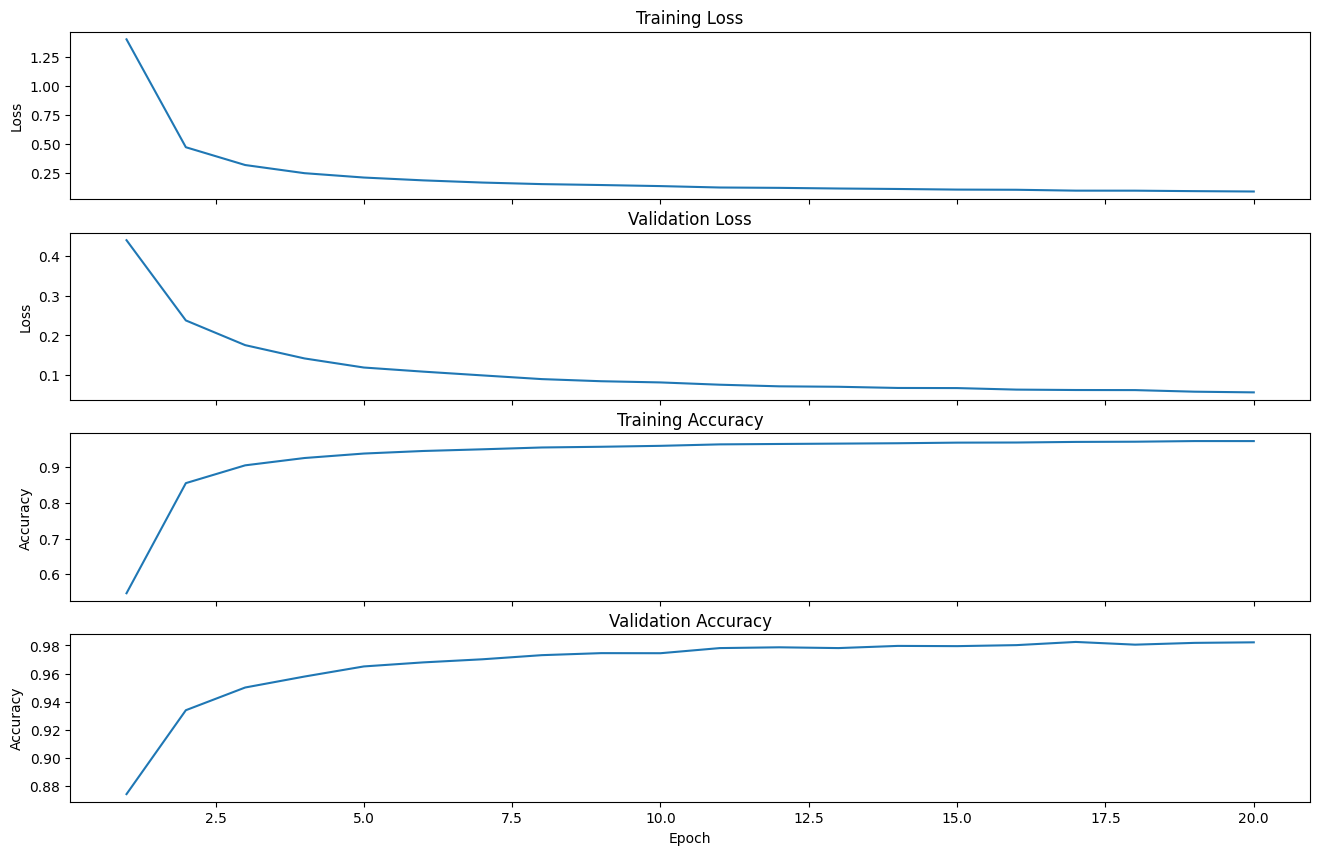

In [2]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 5, 5)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        # NOTE: Lav en max_pool2d her
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "extra_max_pool",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Hvad hvis vi bruger større kerner? Prøv kerne størrelse på 4 istedet for 2 i de to max pooling lage. Sådan at billederne bliver mindre. **Husk at opdaterer kerne størrelse + stride for conv3**:

  5%|▌         | 1/20 [00:08<02:36,  8.22s/it, Train_loss=2.265, Val_loss=2.169, Train_acc=0.196, Val_acc=0.429, Time_Taken=8.186s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.4287455674815685 i 'saved_models/extra_max_pool4_best.pt'


 10%|█         | 2/20 [00:16<02:29,  8.29s/it, Train_loss=1.896, Val_loss=1.379, Train_acc=0.361, Val_acc=0.638, Time_Taken=8.307s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.6377437945376051 i 'saved_models/extra_max_pool4_best.pt'


 15%|█▌        | 3/20 [00:24<02:14,  7.91s/it, Train_loss=1.273, Val_loss=0.814, Train_acc=0.568, Val_acc=0.782, Time_Taken=7.411s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.7824689720539336 i 'saved_models/extra_max_pool4_best.pt'


 20%|██        | 4/20 [00:32<02:09,  8.07s/it, Train_loss=0.909, Val_loss=0.543, Train_acc=0.705, Val_acc=0.851, Time_Taken=8.274s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.8505097519844136 i 'saved_models/extra_max_pool4_best.pt'


 25%|██▌       | 5/20 [00:40<01:58,  7.93s/it, Train_loss=0.705, Val_loss=0.409, Train_acc=0.778, Val_acc=0.888, Time_Taken=7.631s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.8881316489361702 i 'saved_models/extra_max_pool4_best.pt'


 30%|███       | 6/20 [00:48<01:51,  7.96s/it, Train_loss=0.574, Val_loss=0.316, Train_acc=0.822, Val_acc=0.910, Time_Taken=7.979s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9104609933305294 i 'saved_models/extra_max_pool4_best.pt'


 35%|███▌      | 7/20 [00:56<01:44,  8.06s/it, Train_loss=0.481, Val_loss=0.262, Train_acc=0.854, Val_acc=0.924, Time_Taken=8.219s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9242021276595744 i 'saved_models/extra_max_pool4_best.pt'


 40%|████      | 8/20 [01:03<01:34,  7.86s/it, Train_loss=0.420, Val_loss=0.234, Train_acc=0.874, Val_acc=0.930, Time_Taken=7.400s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9302969860269669 i 'saved_models/extra_max_pool4_best.pt'


 45%|████▌     | 9/20 [01:12<01:28,  8.00s/it, Train_loss=0.372, Val_loss=0.196, Train_acc=0.888, Val_acc=0.940, Time_Taken=8.283s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9404920212765957 i 'saved_models/extra_max_pool4_best.pt'


 50%|█████     | 10/20 [01:19<01:19,  7.96s/it, Train_loss=0.339, Val_loss=0.183, Train_acc=0.899, Val_acc=0.948, Time_Taken=7.802s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9478058510638298 i 'saved_models/extra_max_pool4_best.pt'


 55%|█████▌    | 11/20 [01:27<01:11,  7.94s/it, Train_loss=0.308, Val_loss=0.158, Train_acc=0.909, Val_acc=0.953, Time_Taken=7.850s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9534574468085106 i 'saved_models/extra_max_pool4_best.pt'


 60%|██████    | 12/20 [01:36<01:04,  8.07s/it, Train_loss=0.283, Val_loss=0.152, Train_acc=0.916, Val_acc=0.955, Time_Taken=8.328s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9552859042553191 i 'saved_models/extra_max_pool4_best.pt'


 65%|██████▌   | 13/20 [01:43<00:54,  7.85s/it, Train_loss=0.267, Val_loss=0.142, Train_acc=0.920, Val_acc=0.959, Time_Taken=7.320s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9586103723404256 i 'saved_models/extra_max_pool4_best.pt'


 70%|███████   | 14/20 [01:51<00:47,  7.99s/it, Train_loss=0.248, Val_loss=0.131, Train_acc=0.926, Val_acc=0.963, Time_Taken=8.263s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9629321808510638 i 'saved_models/extra_max_pool4_best.pt'


 75%|███████▌  | 15/20 [01:59<00:39,  7.98s/it, Train_loss=0.240, Val_loss=0.135, Train_acc=0.928, Val_acc=0.958, Time_Taken=7.923s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'


 80%|████████  | 16/20 [02:07<00:31,  7.92s/it, Train_loss=0.232, Val_loss=0.128, Train_acc=0.930, Val_acc=0.962, Time_Taken=7.738s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'


 85%|████████▌ | 17/20 [02:15<00:24,  8.05s/it, Train_loss=0.217, Val_loss=0.113, Train_acc=0.936, Val_acc=0.968, Time_Taken=8.317s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9675310285801583 i 'saved_models/extra_max_pool4_best.pt'


 90%|█████████ | 18/20 [02:23<00:15,  7.84s/it, Train_loss=0.210, Val_loss=0.113, Train_acc=0.937, Val_acc=0.966, Time_Taken=7.331s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'


 95%|█████████▌| 19/20 [02:31<00:07,  7.99s/it, Train_loss=0.203, Val_loss=0.106, Train_acc=0.940, Val_acc=0.968, Time_Taken=8.303s]

Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9676972519844136 i 'saved_models/extra_max_pool4_best.pt'


100%|██████████| 20/20 [02:39<00:00,  7.99s/it, Train_loss=0.194, Val_loss=0.106, Train_acc=0.942, Val_acc=0.968, Time_Taken=8.121s]


Gemt modellen fra sidste checkpoint i 'saved_models/extra_max_pool4.pt'
Gemt modellen med bedste accuracy 0.9684175531914894 i 'saved_models/extra_max_pool4_best.pt'
Træning er færdigt. Træning tog 158.98500202300056s og average epoch tid var 7.949250101150028


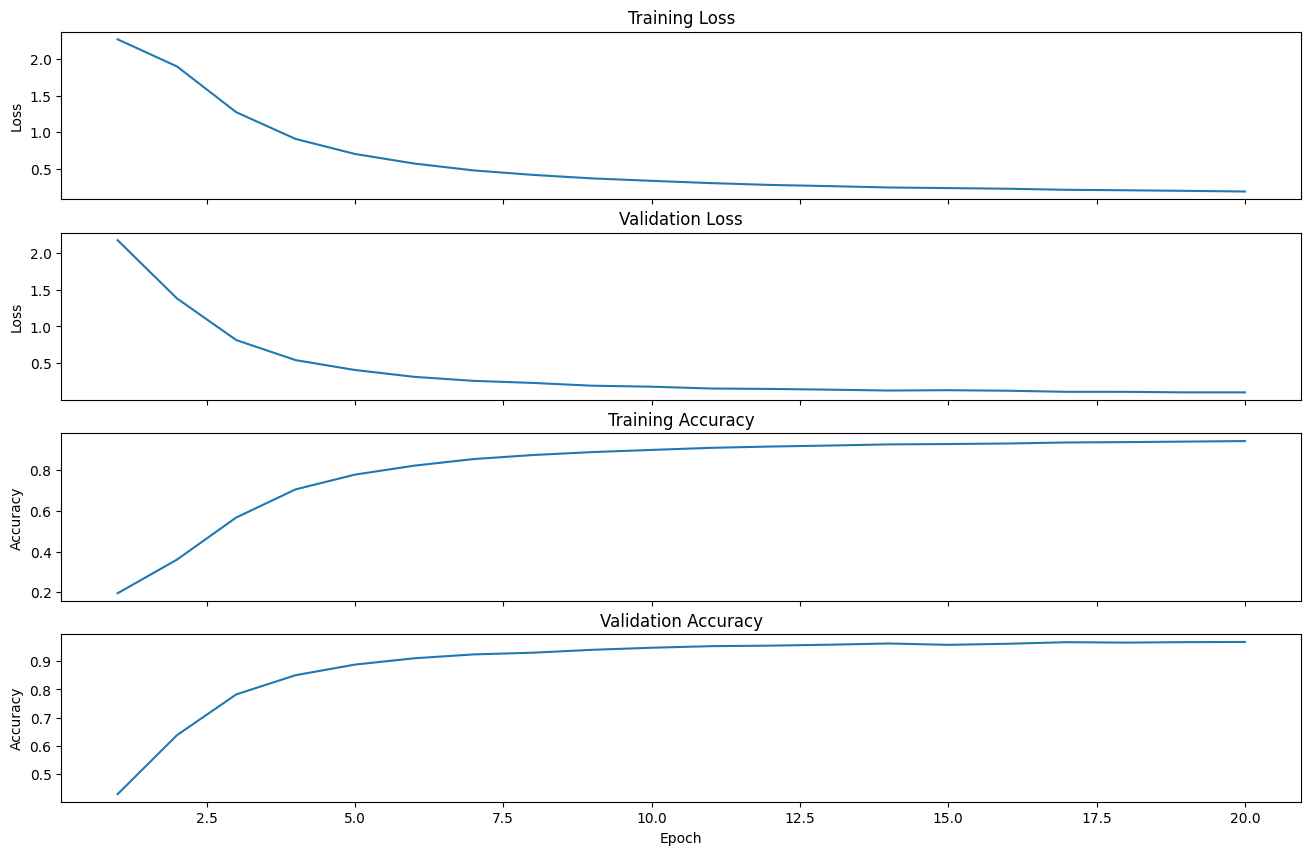

In [3]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 1, 1)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "extra_max_pool4",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Sammenlign de sidste tre modeler der bruger forskellige max pooling lag med den initial model. Hvorfor tror du der er forskel i træning hastighed og accuracy?

### Aktivering funktionet
Aktivering funktionerne er brugt til at gør sikkert at modelen kan også lære mønstre på ulineart data, da en model uden aktivering kan kun finde lineart afhængigheder mellem dataen. Hvis man fjerner alle aktivering funktioner, så bliver det til linær aktiverin, da ingen aktivering er bare $f(x)=x$, som er linear aktiveringsfunktion.

Man kan også skift aktivering funktion til en anden ved at bruge et andet funktion end F.relu. Man kan finde resten af funktionerne [her](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions).

Træn en model der bruger kun linear aktivering (ingen aktivering), fjern ikke F.log_softmax, fordi den bruges til at lave netværkets output vektor til en sandsynlighedsvektor:

  5%|▌         | 1/20 [00:10<03:23, 10.73s/it, Train_loss=0.593, Val_loss=0.341, Train_acc=0.834, Val_acc=0.894, Time_Taken=10.628s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.8942265073035626 i 'saved_models/linear_model_best.pt'


 10%|█         | 2/20 [00:20<03:05, 10.32s/it, Train_loss=0.351, Val_loss=0.300, Train_acc=0.897, Val_acc=0.913, Time_Taken=9.946s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9130651595744681 i 'saved_models/linear_model_best.pt'


 15%|█▌        | 3/20 [00:30<02:48,  9.89s/it, Train_loss=0.304, Val_loss=0.258, Train_acc=0.911, Val_acc=0.925, Time_Taken=9.327s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9247562060964868 i 'saved_models/linear_model_best.pt'


 20%|██        | 4/20 [00:40<02:39,  9.99s/it, Train_loss=0.255, Val_loss=0.211, Train_acc=0.928, Val_acc=0.939, Time_Taken=10.077s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9390514188624443 i 'saved_models/linear_model_best.pt'


 25%|██▌       | 5/20 [00:50<02:30, 10.03s/it, Train_loss=0.204, Val_loss=0.166, Train_acc=0.942, Val_acc=0.952, Time_Taken=10.060s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9524601063829787 i 'saved_models/linear_model_best.pt'


 30%|███       | 6/20 [01:00<02:20, 10.06s/it, Train_loss=0.165, Val_loss=0.139, Train_acc=0.953, Val_acc=0.961, Time_Taken=10.062s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9609375 i 'saved_models/linear_model_best.pt'


 35%|███▌      | 7/20 [01:09<02:07,  9.84s/it, Train_loss=0.140, Val_loss=0.115, Train_acc=0.961, Val_acc=0.970, Time_Taken=9.337s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9696919328354775 i 'saved_models/linear_model_best.pt'


 40%|████      | 8/20 [01:19<01:58,  9.91s/it, Train_loss=0.122, Val_loss=0.104, Train_acc=0.965, Val_acc=0.970, Time_Taken=10.002s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9699135638297872 i 'saved_models/linear_model_best.pt'


 45%|████▌     | 9/20 [01:30<01:49,  9.96s/it, Train_loss=0.109, Val_loss=0.096, Train_acc=0.968, Val_acc=0.973, Time_Taken=10.026s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9725731382978723 i 'saved_models/linear_model_best.pt'


 50%|█████     | 10/20 [01:40<01:40, 10.10s/it, Train_loss=0.101, Val_loss=0.086, Train_acc=0.970, Val_acc=0.974, Time_Taken=10.342s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.974179964750371 i 'saved_models/linear_model_best.pt'


 55%|█████▌    | 11/20 [01:49<01:28,  9.88s/it, Train_loss=0.093, Val_loss=0.087, Train_acc=0.972, Val_acc=0.975, Time_Taken=9.304s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.975177305175903 i 'saved_models/linear_model_best.pt'


 60%|██████    | 12/20 [01:59<01:19,  9.93s/it, Train_loss=0.091, Val_loss=0.082, Train_acc=0.973, Val_acc=0.975, Time_Taken=9.997s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'


 65%|██████▌   | 13/20 [02:10<01:11, 10.21s/it, Train_loss=0.086, Val_loss=0.080, Train_acc=0.975, Val_acc=0.977, Time_Taken=10.795s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9773382094312222 i 'saved_models/linear_model_best.pt'


 70%|███████   | 14/20 [02:20<01:01, 10.17s/it, Train_loss=0.081, Val_loss=0.077, Train_acc=0.976, Val_acc=0.977, Time_Taken=10.046s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'


 75%|███████▌  | 15/20 [02:30<00:50, 10.02s/it, Train_loss=0.079, Val_loss=0.079, Train_acc=0.976, Val_acc=0.977, Time_Taken=9.594s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'


 80%|████████  | 16/20 [02:40<00:39,  9.97s/it, Train_loss=0.075, Val_loss=0.074, Train_acc=0.977, Val_acc=0.978, Time_Taken=9.808s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9781139188624443 i 'saved_models/linear_model_best.pt'


 85%|████████▌ | 17/20 [02:50<00:30, 10.01s/it, Train_loss=0.073, Val_loss=0.075, Train_acc=0.978, Val_acc=0.978, Time_Taken=10.051s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9783909574468085 i 'saved_models/linear_model_best.pt'


 90%|█████████ | 18/20 [03:00<00:20, 10.02s/it, Train_loss=0.072, Val_loss=0.077, Train_acc=0.978, Val_acc=0.978, Time_Taken=9.995s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'


 95%|█████████▌| 19/20 [03:10<00:09,  9.95s/it, Train_loss=0.067, Val_loss=0.073, Train_acc=0.979, Val_acc=0.979, Time_Taken=9.711s]

Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9788896276595744 i 'saved_models/linear_model_best.pt'


100%|██████████| 20/20 [03:20<00:00, 10.00s/it, Train_loss=0.067, Val_loss=0.070, Train_acc=0.979, Val_acc=0.980, Time_Taken=9.675s]


Gemt modellen fra sidste checkpoint i 'saved_models/linear_model.pt'
Gemt modellen med bedste accuracy 0.9796653370907966 i 'saved_models/linear_model_best.pt'
Træning er færdigt. Træning tog 198.78437729699908s og average epoch tid var 9.939218864849954


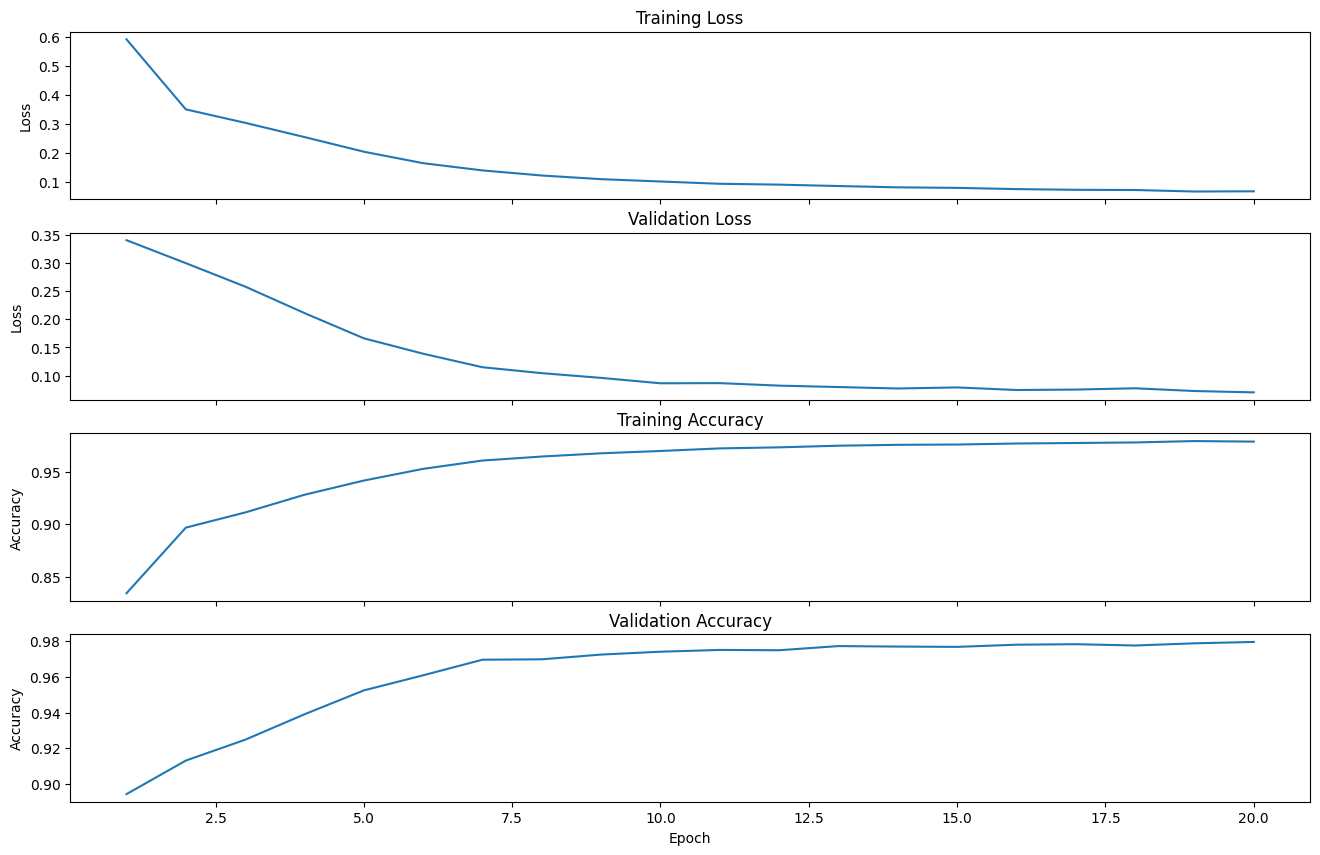

In [2]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 12, 12)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        # NOTE: Fjern de linjer som kører relu aktivering
        x = self.conv1(x)
        #x = F.relu(x)
        x = self.conv2(x)
        #x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        #x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "linear_model",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Der findes også andre ikke lineart funktioner, prøv sigmoid og tanh aktivering funktionerne:

  5%|▌         | 1/20 [00:09<03:03,  9.65s/it, Train_loss=2.312, Val_loss=2.303, Train_acc=0.105, Val_acc=0.107, Time_Taken=9.601s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'
Gemt modellen med bedste accuracy 0.10715868795647267 i 'saved_models/different_activation1_best.pt'


 10%|█         | 2/20 [00:19<03:00, 10.03s/it, Train_loss=2.303, Val_loss=2.302, Train_acc=0.108, Val_acc=0.107, Time_Taken=10.241s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'
Gemt modellen med bedste accuracy 0.10721409574468085 i 'saved_models/different_activation1_best.pt'


 15%|█▌        | 3/20 [00:30<02:52, 10.14s/it, Train_loss=2.302, Val_loss=2.302, Train_acc=0.111, Val_acc=0.107, Time_Taken=10.227s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'
Gemt modellen med bedste accuracy 0.10749113480461404 i 'saved_models/different_activation1_best.pt'


 20%|██        | 4/20 [00:40<02:43, 10.20s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.112, Val_acc=0.107, Time_Taken=10.254s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 25%|██▌       | 5/20 [00:50<02:31, 10.08s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.112, Val_acc=0.107, Time_Taken=9.789s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 30%|███       | 6/20 [01:00<02:20, 10.03s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.112, Val_acc=0.107, Time_Taken=9.891s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 35%|███▌      | 7/20 [01:10<02:11, 10.10s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.113, Val_acc=0.107, Time_Taken=10.202s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 40%|████      | 8/20 [01:20<02:01, 10.16s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.113, Val_acc=0.107, Time_Taken=10.252s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 45%|████▌     | 9/20 [01:30<01:51, 10.12s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.113, Val_acc=0.107, Time_Taken=9.983s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 50%|█████     | 10/20 [01:40<01:40, 10.01s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.113, Val_acc=0.107, Time_Taken=9.719s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 55%|█████▌    | 11/20 [01:50<01:30, 10.10s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.113, Val_acc=0.107, Time_Taken=10.261s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 60%|██████    | 12/20 [02:01<01:21, 10.15s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.113, Val_acc=0.107, Time_Taken=10.220s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 65%|██████▌   | 13/20 [02:11<01:11, 10.20s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.114, Val_acc=0.107, Time_Taken=10.275s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 70%|███████   | 14/20 [02:21<01:00, 10.03s/it, Train_loss=2.301, Val_loss=2.302, Train_acc=0.114, Val_acc=0.107, Time_Taken=9.564s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 75%|███████▌  | 15/20 [02:31<00:50, 10.09s/it, Train_loss=2.300, Val_loss=2.301, Train_acc=0.113, Val_acc=0.107, Time_Taken=10.205s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 80%|████████  | 16/20 [02:41<00:40, 10.15s/it, Train_loss=2.300, Val_loss=2.301, Train_acc=0.114, Val_acc=0.108, Time_Taken=10.238s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'
Gemt modellen med bedste accuracy 0.10754654255319149 i 'saved_models/different_activation1_best.pt'


 85%|████████▌ | 17/20 [02:51<00:30, 10.19s/it, Train_loss=2.300, Val_loss=2.301, Train_acc=0.113, Val_acc=0.107, Time_Taken=10.248s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


 90%|█████████ | 18/20 [03:01<00:20, 10.10s/it, Train_loss=2.300, Val_loss=2.300, Train_acc=0.114, Val_acc=0.108, Time_Taken=9.786s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'
Gemt modellen med bedste accuracy 0.10776817386454725 i 'saved_models/different_activation1_best.pt'


 95%|█████████▌| 19/20 [03:11<00:10, 10.06s/it, Train_loss=2.299, Val_loss=2.300, Train_acc=0.114, Val_acc=0.107, Time_Taken=9.924s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'


100%|██████████| 20/20 [03:22<00:00, 10.11s/it, Train_loss=2.299, Val_loss=2.300, Train_acc=0.117, Val_acc=0.107, Time_Taken=10.308s]


Gemt modellen fra sidste checkpoint i 'saved_models/different_activation1.pt'
Træning er færdigt. Træning tog 201.1875896590027s og average epoch tid var 10.059379482950135


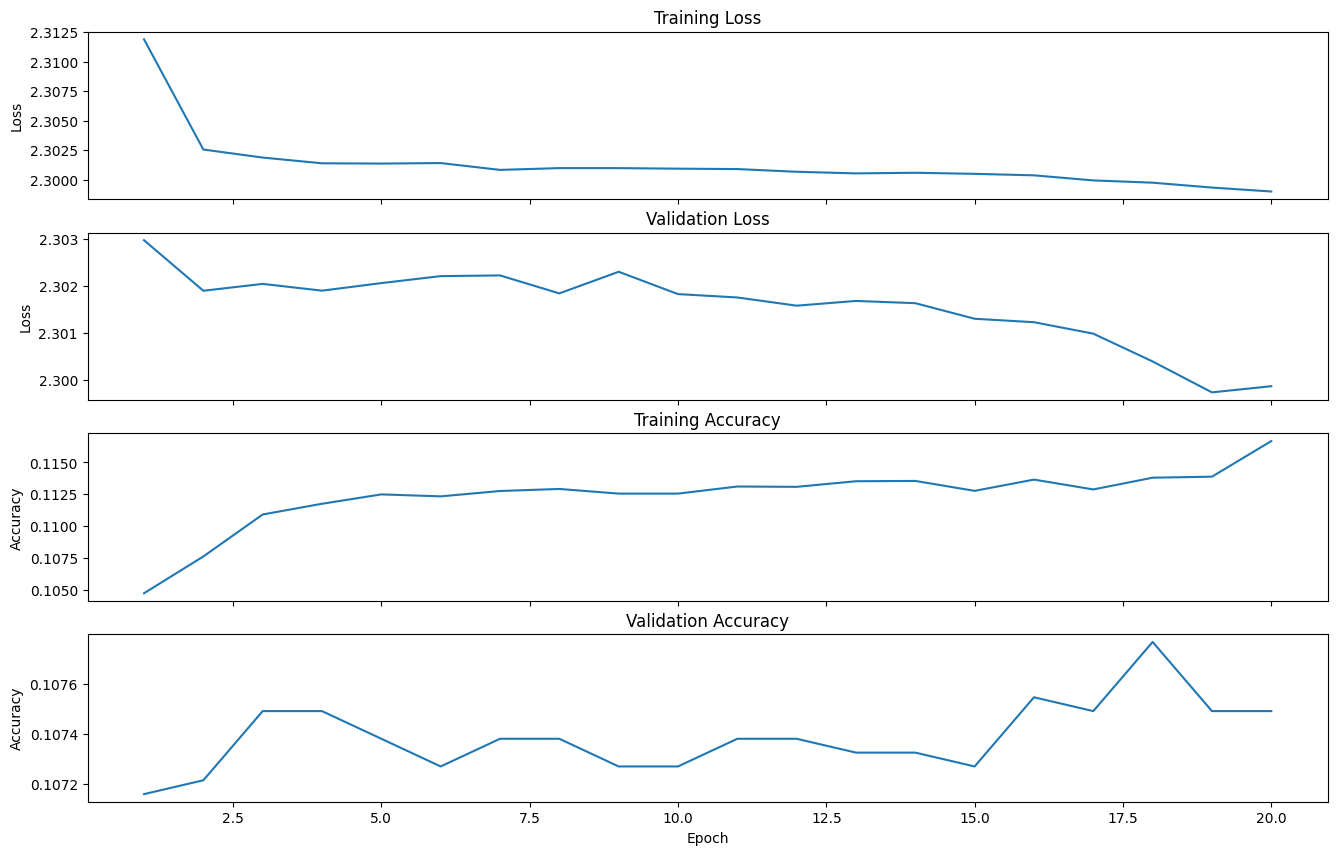

In [3]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 12, 12)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        # NOTE: Skift F.relu med F.sigmoid eller F.tanh
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "different_activation1",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

  5%|▌         | 1/20 [00:09<03:02,  9.60s/it, Train_loss=0.725, Val_loss=0.349, Train_acc=0.817, Val_acc=0.895, Time_Taken=9.543s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.8950022167347848 i 'saved_models/different_activation2_best.pt'


 10%|█         | 2/20 [00:19<03:00, 10.01s/it, Train_loss=0.328, Val_loss=0.283, Train_acc=0.906, Val_acc=0.912, Time_Taken=10.240s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9122894507773379 i 'saved_models/different_activation2_best.pt'


 15%|█▌        | 3/20 [00:30<02:52, 10.17s/it, Train_loss=0.278, Val_loss=0.243, Train_acc=0.918, Val_acc=0.926, Time_Taken=10.295s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9259197699262741 i 'saved_models/different_activation2_best.pt'


 20%|██        | 4/20 [00:40<02:43, 10.20s/it, Train_loss=0.241, Val_loss=0.213, Train_acc=0.929, Val_acc=0.937, Time_Taken=10.204s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9366688829787234 i 'saved_models/different_activation2_best.pt'


 25%|██▌       | 5/20 [00:50<02:31, 10.08s/it, Train_loss=0.219, Val_loss=0.186, Train_acc=0.936, Val_acc=0.943, Time_Taken=9.774s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9425975179418604 i 'saved_models/different_activation2_best.pt'


 30%|███       | 6/20 [01:00<02:21, 10.08s/it, Train_loss=0.198, Val_loss=0.174, Train_acc=0.942, Val_acc=0.947, Time_Taken=10.024s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9469747340425532 i 'saved_models/different_activation2_best.pt'


 35%|███▌      | 7/20 [01:10<02:11, 10.13s/it, Train_loss=0.180, Val_loss=0.151, Train_acc=0.947, Val_acc=0.956, Time_Taken=10.177s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9556737592879762 i 'saved_models/different_activation2_best.pt'


 40%|████      | 8/20 [01:20<02:02, 10.17s/it, Train_loss=0.167, Val_loss=0.142, Train_acc=0.950, Val_acc=0.958, Time_Taken=10.208s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9577238477290945 i 'saved_models/different_activation2_best.pt'


 45%|████▌     | 9/20 [01:31<01:51, 10.16s/it, Train_loss=0.150, Val_loss=0.127, Train_acc=0.956, Val_acc=0.963, Time_Taken=10.053s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9625997340425532 i 'saved_models/different_activation2_best.pt'


 50%|█████     | 10/20 [01:40<01:40, 10.03s/it, Train_loss=0.138, Val_loss=0.120, Train_acc=0.960, Val_acc=0.964, Time_Taken=9.690s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9643727838993073 i 'saved_models/different_activation2_best.pt'


 55%|█████▌    | 11/20 [01:51<01:30, 10.11s/it, Train_loss=0.128, Val_loss=0.110, Train_acc=0.962, Val_acc=0.967, Time_Taken=10.230s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9665890957446809 i 'saved_models/different_activation2_best.pt'


 60%|██████    | 12/20 [02:01<01:21, 10.17s/it, Train_loss=0.117, Val_loss=0.102, Train_acc=0.966, Val_acc=0.968, Time_Taken=10.243s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9681959221971795 i 'saved_models/different_activation2_best.pt'


 65%|██████▌   | 13/20 [02:11<01:11, 10.20s/it, Train_loss=0.110, Val_loss=0.096, Train_acc=0.967, Val_acc=0.969, Time_Taken=10.242s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9693594860269669 i 'saved_models/different_activation2_best.pt'


 70%|███████   | 14/20 [02:21<01:00, 10.01s/it, Train_loss=0.103, Val_loss=0.091, Train_acc=0.970, Val_acc=0.972, Time_Taken=9.466s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.971520390282286 i 'saved_models/different_activation2_best.pt'


 75%|███████▌  | 15/20 [02:31<00:50, 10.09s/it, Train_loss=0.097, Val_loss=0.085, Train_acc=0.972, Val_acc=0.972, Time_Taken=10.223s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9719636529049975 i 'saved_models/different_activation2_best.pt'


 80%|████████  | 16/20 [02:41<00:40, 10.13s/it, Train_loss=0.092, Val_loss=0.082, Train_acc=0.973, Val_acc=0.975, Time_Taken=10.182s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9750110817716476 i 'saved_models/different_activation2_best.pt'


 85%|████████▌ | 17/20 [02:51<00:30, 10.15s/it, Train_loss=0.087, Val_loss=0.078, Train_acc=0.974, Val_acc=0.976, Time_Taken=10.147s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9759530146071251 i 'saved_models/different_activation2_best.pt'


 90%|█████████ | 18/20 [03:01<00:20, 10.05s/it, Train_loss=0.083, Val_loss=0.073, Train_acc=0.975, Val_acc=0.977, Time_Taken=9.734s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9770057626227115 i 'saved_models/different_activation2_best.pt'


 95%|█████████▌| 19/20 [03:11<00:10, 10.02s/it, Train_loss=0.080, Val_loss=0.072, Train_acc=0.976, Val_acc=0.978, Time_Taken=9.880s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Gemt modellen med bedste accuracy 0.9778368796439881 i 'saved_models/different_activation2_best.pt'


100%|██████████| 20/20 [03:21<00:00, 10.09s/it, Train_loss=0.078, Val_loss=0.074, Train_acc=0.977, Val_acc=0.977, Time_Taken=10.143s]


Gemt modellen fra sidste checkpoint i 'saved_models/different_activation2.pt'
Træning er færdigt. Træning tog 200.6989514270017s og average epoch tid var 10.034947571350084


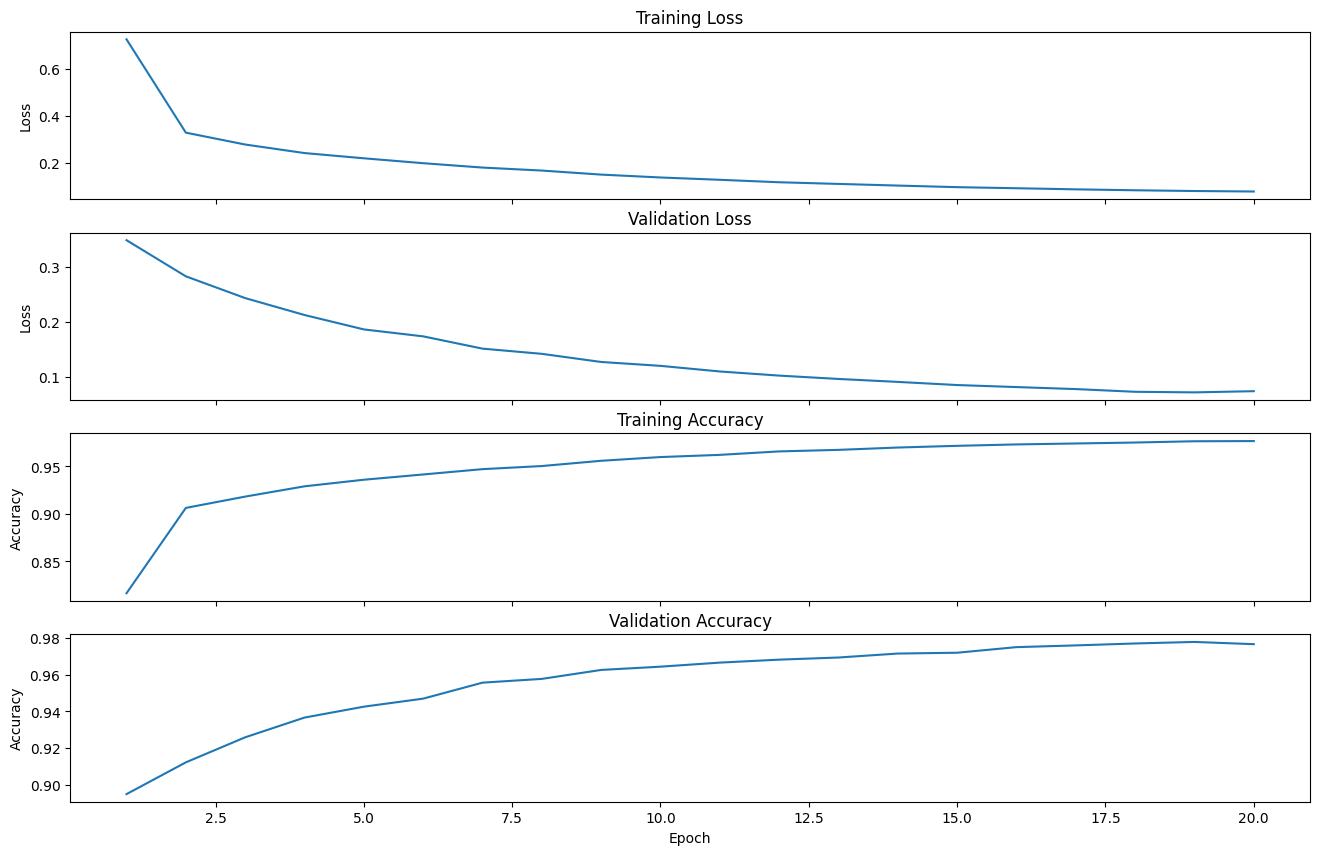

In [4]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 12, 12)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        # NOTE: Skift F.relu med F.tanh eller F.sigmoid
        x = self.conv1(x)
        x = F.tanh(x)
        x = self.conv2(x)
        x = F.tanh(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.tanh(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "different_activation2",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Sammenlign de forskellige aktiveringsfunktioner. Skal man altid bruge et non-lineart aktiveringsfunktion? Får man hurtigere træning ved at bruge lineart aktivering istedet for ikke lineart aktivering? Er de andre aktivering funktioner så god som RELU?

## Opgave: Undersøg træning parameter
Det er ikke kun modellen der er vigtig for at få god resultater. Selve træning processen er også vigtigt.

Epochen bestemer hvor langt modellen skal træn, for mange epocher kan resulterer i overfitting, og for færre epocher resulterer i underfitting.

Batch størrelsen bestemmer hvor mange data punkter man bruge til at adjusterer vægtene med og hvor mange steps man tager per epoch som bestemmer hvor hurtigt vægtene ændres. Større batches resulterer i mere præcise vægt ændringer, men kan også resultarer i langsommere træning.

Der også findes mange forskellige optimering algoritmer der opdaterer vægtene.

### Antal Epocher
Nu skal du undersøg om de førrig modeller underfitter. Prøv at øve antal epocher og se hvordan accuracy ændres. Pas på med at gå alt for stort, da flere epocher tager mere tid til at træne prøv at ikke gå over 80:

  2%|▏         | 1/50 [00:10<08:40, 10.62s/it, Train_loss=0.929, Val_loss=0.288, Train_acc=0.723, Val_acc=0.914, Time_Taken=10.526s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9137854614156358 i 'saved_models/different_epochs_best.pt'


  4%|▍         | 2/50 [00:21<08:28, 10.60s/it, Train_loss=0.344, Val_loss=0.214, Train_acc=0.896, Val_acc=0.938, Time_Taken=10.502s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9381648936170213 i 'saved_models/different_epochs_best.pt'


  6%|▌         | 3/50 [00:31<08:14, 10.52s/it, Train_loss=0.284, Val_loss=0.171, Train_acc=0.915, Val_acc=0.947, Time_Taken=10.362s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9465314720539336 i 'saved_models/different_epochs_best.pt'


  8%|▊         | 4/50 [00:41<07:58, 10.41s/it, Train_loss=0.251, Val_loss=0.152, Train_acc=0.924, Val_acc=0.952, Time_Taken=10.189s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9517952127659575 i 'saved_models/different_epochs_best.pt'


 10%|█         | 5/50 [00:52<07:45, 10.35s/it, Train_loss=0.227, Val_loss=0.137, Train_acc=0.931, Val_acc=0.957, Time_Taken=10.209s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9574468085106383 i 'saved_models/different_epochs_best.pt'


 12%|█▏        | 6/50 [01:02<07:33, 10.30s/it, Train_loss=0.213, Val_loss=0.120, Train_acc=0.935, Val_acc=0.963, Time_Taken=10.118s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.96320922006952 i 'saved_models/different_epochs_best.pt'


 14%|█▍        | 7/50 [01:11<07:13, 10.09s/it, Train_loss=0.196, Val_loss=0.114, Train_acc=0.941, Val_acc=0.962, Time_Taken=9.619s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 16%|█▌        | 8/50 [01:22<07:05, 10.14s/it, Train_loss=0.184, Val_loss=0.105, Train_acc=0.945, Val_acc=0.967, Time_Taken=10.193s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9665890957446809 i 'saved_models/different_epochs_best.pt'


 18%|█▊        | 9/50 [01:32<06:56, 10.17s/it, Train_loss=0.174, Val_loss=0.102, Train_acc=0.947, Val_acc=0.966, Time_Taken=10.185s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 20%|██        | 10/50 [01:42<06:48, 10.22s/it, Train_loss=0.163, Val_loss=0.094, Train_acc=0.951, Val_acc=0.972, Time_Taken=10.268s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9720190604950519 i 'saved_models/different_epochs_best.pt'


 22%|██▏       | 11/50 [01:52<06:32, 10.06s/it, Train_loss=0.152, Val_loss=0.089, Train_acc=0.954, Val_acc=0.970, Time_Taken=9.639s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 24%|██▍       | 12/50 [02:02<06:22, 10.07s/it, Train_loss=0.142, Val_loss=0.085, Train_acc=0.957, Val_acc=0.974, Time_Taken=10.038s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9736812945376051 i 'saved_models/different_epochs_best.pt'


 26%|██▌       | 13/50 [02:12<06:14, 10.13s/it, Train_loss=0.135, Val_loss=0.076, Train_acc=0.960, Val_acc=0.976, Time_Taken=10.216s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.976063829787234 i 'saved_models/different_epochs_best.pt'


 28%|██▊       | 14/50 [02:23<06:05, 10.17s/it, Train_loss=0.128, Val_loss=0.074, Train_acc=0.961, Val_acc=0.978, Time_Taken=10.196s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9781139188624443 i 'saved_models/different_epochs_best.pt'


 30%|███       | 15/50 [02:32<05:52, 10.07s/it, Train_loss=0.119, Val_loss=0.069, Train_acc=0.964, Val_acc=0.978, Time_Taken=9.781s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 32%|███▏      | 16/50 [02:42<05:40, 10.02s/it, Train_loss=0.115, Val_loss=0.065, Train_acc=0.966, Val_acc=0.979, Time_Taken=9.854s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9793882978723404 i 'saved_models/different_epochs_best.pt'


 34%|███▍      | 17/50 [02:53<05:32, 10.08s/it, Train_loss=0.107, Val_loss=0.064, Train_acc=0.968, Val_acc=0.981, Time_Taken=10.170s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.981216755319149 i 'saved_models/different_epochs_best.pt'


 36%|███▌      | 18/50 [03:03<05:24, 10.14s/it, Train_loss=0.105, Val_loss=0.059, Train_acc=0.969, Val_acc=0.981, Time_Taken=10.235s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9813829787234043 i 'saved_models/different_epochs_best.pt'


 38%|███▊      | 19/50 [03:13<05:14, 10.14s/it, Train_loss=0.096, Val_loss=0.056, Train_acc=0.971, Val_acc=0.983, Time_Taken=10.028s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.982989805175903 i 'saved_models/different_epochs_best.pt'


 40%|████      | 20/50 [03:23<04:59,  9.99s/it, Train_loss=0.091, Val_loss=0.053, Train_acc=0.972, Val_acc=0.983, Time_Taken=9.607s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9833222519844136 i 'saved_models/different_epochs_best.pt'


 42%|████▏     | 21/50 [03:33<04:51, 10.05s/it, Train_loss=0.087, Val_loss=0.053, Train_acc=0.973, Val_acc=0.984, Time_Taken=10.142s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9840425531914894 i 'saved_models/different_epochs_best.pt'


 44%|████▍     | 22/50 [03:43<04:42, 10.10s/it, Train_loss=0.083, Val_loss=0.051, Train_acc=0.975, Val_acc=0.984, Time_Taken=10.144s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.984375 i 'saved_models/different_epochs_best.pt'


 46%|████▌     | 23/50 [03:53<04:33, 10.14s/it, Train_loss=0.082, Val_loss=0.048, Train_acc=0.975, Val_acc=0.986, Time_Taken=10.181s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9861480498567541 i 'saved_models/different_epochs_best.pt'


 48%|████▊     | 24/50 [04:03<04:18,  9.95s/it, Train_loss=0.078, Val_loss=0.046, Train_acc=0.977, Val_acc=0.987, Time_Taken=9.434s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.98664672006952 i 'saved_models/different_epochs_best.pt'


 50%|█████     | 25/50 [04:13<04:11, 10.05s/it, Train_loss=0.074, Val_loss=0.046, Train_acc=0.978, Val_acc=0.987, Time_Taken=10.227s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9872007978723404 i 'saved_models/different_epochs_best.pt'


 52%|█████▏    | 26/50 [04:23<04:02, 10.10s/it, Train_loss=0.074, Val_loss=0.045, Train_acc=0.978, Val_acc=0.986, Time_Taken=10.191s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 54%|█████▍    | 27/50 [04:34<03:53, 10.14s/it, Train_loss=0.069, Val_loss=0.045, Train_acc=0.980, Val_acc=0.987, Time_Taken=10.178s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9873670212765957 i 'saved_models/different_epochs_best.pt'


 56%|█████▌    | 28/50 [04:43<03:40, 10.03s/it, Train_loss=0.066, Val_loss=0.043, Train_acc=0.979, Val_acc=0.989, Time_Taken=9.673s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.988530585106383 i 'saved_models/different_epochs_best.pt'


 58%|█████▊    | 29/50 [04:53<03:30, 10.02s/it, Train_loss=0.064, Val_loss=0.043, Train_acc=0.980, Val_acc=0.987, Time_Taken=9.965s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 60%|██████    | 30/50 [05:03<03:21, 10.07s/it, Train_loss=0.063, Val_loss=0.041, Train_acc=0.980, Val_acc=0.988, Time_Taken=10.141s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 62%|██████▏   | 31/50 [05:14<03:12, 10.13s/it, Train_loss=0.060, Val_loss=0.040, Train_acc=0.981, Val_acc=0.989, Time_Taken=10.207s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9886968085106383 i 'saved_models/different_epochs_best.pt'


 64%|██████▍   | 32/50 [05:24<03:00, 10.05s/it, Train_loss=0.058, Val_loss=0.041, Train_acc=0.983, Val_acc=0.988, Time_Taken=9.797s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 66%|██████▌   | 33/50 [05:33<02:49,  9.96s/it, Train_loss=0.057, Val_loss=0.040, Train_acc=0.983, Val_acc=0.989, Time_Taken=9.707s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.989029255319149 i 'saved_models/different_epochs_best.pt'


 68%|██████▊   | 34/50 [05:44<02:40, 10.03s/it, Train_loss=0.054, Val_loss=0.039, Train_acc=0.983, Val_acc=0.988, Time_Taken=10.136s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 70%|███████   | 35/50 [05:54<02:31, 10.08s/it, Train_loss=0.051, Val_loss=0.038, Train_acc=0.984, Val_acc=0.989, Time_Taken=10.164s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9893617021276596 i 'saved_models/different_epochs_best.pt'


 72%|███████▏  | 36/50 [06:04<02:21, 10.14s/it, Train_loss=0.054, Val_loss=0.037, Train_acc=0.983, Val_acc=0.990, Time_Taken=10.177s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9900265957446809 i 'saved_models/different_epochs_best.pt'


 74%|███████▍  | 37/50 [06:14<02:09,  9.95s/it, Train_loss=0.048, Val_loss=0.037, Train_acc=0.985, Val_acc=0.990, Time_Taken=9.477s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 76%|███████▌  | 38/50 [06:24<02:00, 10.02s/it, Train_loss=0.050, Val_loss=0.036, Train_acc=0.985, Val_acc=0.989, Time_Taken=10.141s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 78%|███████▊  | 39/50 [06:34<01:50, 10.07s/it, Train_loss=0.048, Val_loss=0.036, Train_acc=0.985, Val_acc=0.990, Time_Taken=10.143s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 80%|████████  | 40/50 [06:44<01:41, 10.13s/it, Train_loss=0.047, Val_loss=0.037, Train_acc=0.985, Val_acc=0.989, Time_Taken=10.219s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 82%|████████▏ | 41/50 [06:54<01:30, 10.02s/it, Train_loss=0.044, Val_loss=0.037, Train_acc=0.986, Val_acc=0.990, Time_Taken=9.677s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 84%|████████▍ | 42/50 [07:04<01:20, 10.06s/it, Train_loss=0.044, Val_loss=0.037, Train_acc=0.986, Val_acc=0.990, Time_Taken=10.123s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9901374115588817 i 'saved_models/different_epochs_best.pt'


 86%|████████▌ | 43/50 [07:14<01:10, 10.12s/it, Train_loss=0.044, Val_loss=0.035, Train_acc=0.986, Val_acc=0.990, Time_Taken=10.203s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9901928191489362 i 'saved_models/different_epochs_best.pt'


 88%|████████▊ | 44/50 [07:25<01:00, 10.13s/it, Train_loss=0.043, Val_loss=0.036, Train_acc=0.987, Val_acc=0.990, Time_Taken=10.109s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 90%|█████████ | 45/50 [07:34<00:50, 10.06s/it, Train_loss=0.041, Val_loss=0.035, Train_acc=0.987, Val_acc=0.990, Time_Taken=9.818s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 92%|█████████▏| 46/50 [07:44<00:39,  9.99s/it, Train_loss=0.040, Val_loss=0.034, Train_acc=0.987, Val_acc=0.991, Time_Taken=9.772s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9905252659574468 i 'saved_models/different_epochs_best.pt'


 94%|█████████▍| 47/50 [07:54<00:30, 10.04s/it, Train_loss=0.039, Val_loss=0.036, Train_acc=0.988, Val_acc=0.990, Time_Taken=10.130s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 96%|█████████▌| 48/50 [08:05<00:20, 10.09s/it, Train_loss=0.039, Val_loss=0.035, Train_acc=0.987, Val_acc=0.990, Time_Taken=10.150s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'


 98%|█████████▊| 49/50 [08:15<00:10, 10.12s/it, Train_loss=0.039, Val_loss=0.034, Train_acc=0.988, Val_acc=0.991, Time_Taken=10.128s]

Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.9906360817716476 i 'saved_models/different_epochs_best.pt'


100%|██████████| 50/50 [08:24<00:00, 10.10s/it, Train_loss=0.037, Val_loss=0.034, Train_acc=0.988, Val_acc=0.991, Time_Taken=9.534s]


Gemt modellen fra sidste checkpoint i 'saved_models/different_epochs.pt'
Gemt modellen med bedste accuracy 0.990802305175903 i 'saved_models/different_epochs_best.pt'
Træning er færdigt. Træning tog 502.02093187800074s og average epoch tid var 10.040418637560014


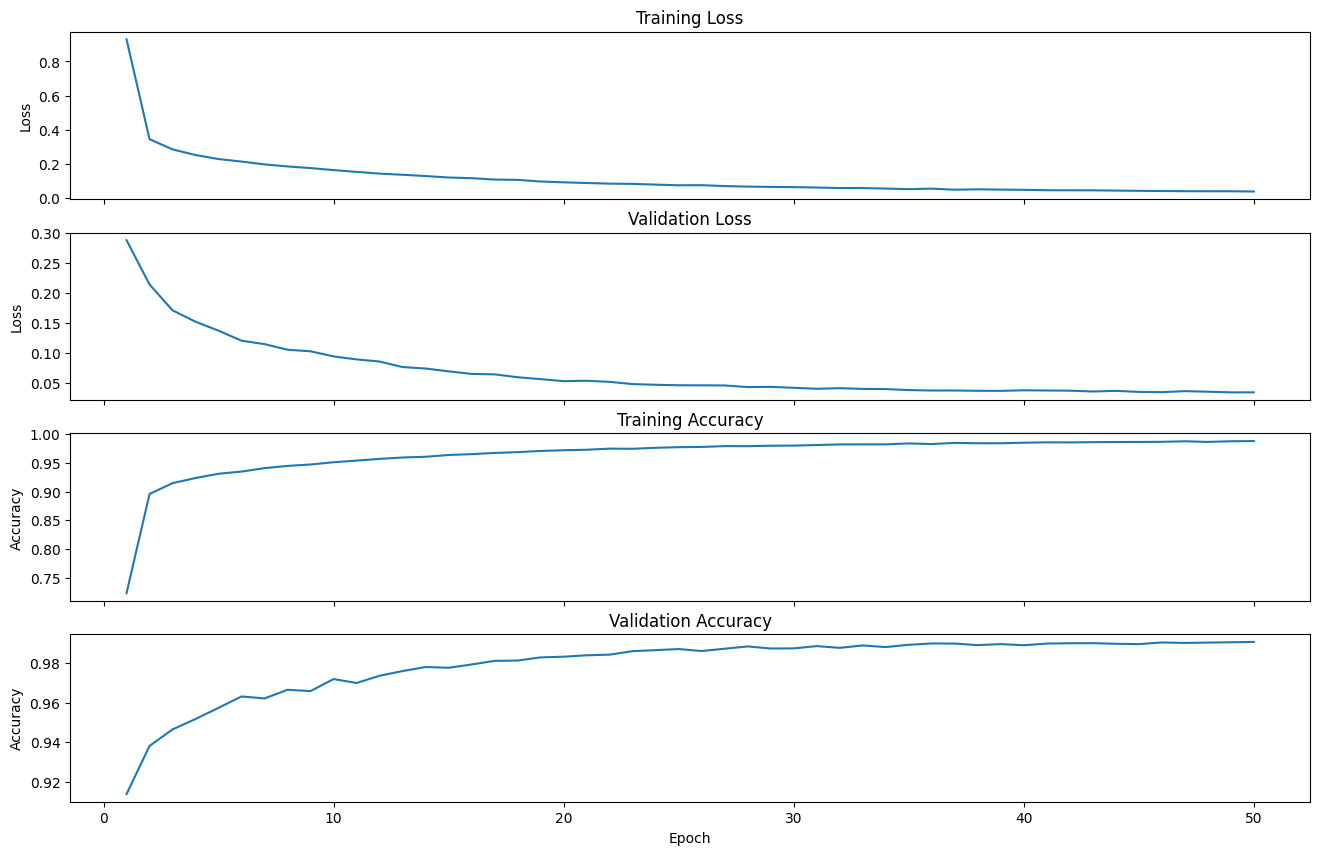

In [2]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 12, 12)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 50,
    optimizer = optim.SGD,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "different_epochs",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Hint: Et måde at finde en god epoch mængde er at starte med et stort epoch tal, og så se hvornår validering accuracy starter med at ændrer sig for lidt mellem hvert epoch (fx. 0.005). Dette strategi kaldes for early stopping, og den bruges for at gøre sikker at modellen træner ikke mere end den har bruge for.

Hvad fandt du til at være en god mængde af epocher? Giver det mening at bruge det ekstra tid til at for den mængde øvede accuracy man får? Hvad hvis din model tog 10 minutter eller en time per epoch?

### Andre optimering algoritmer
Lige nu bruges der SGD som optimering algoritm. Der andre optimizers i pytorch som kan ses [her](https://pytorch.org/docs/stable/optim.html#algorithms) prøv at bruge adam istedet for SGD, som er nyere og er den mest brugt inden for ML lige nu.

  5%|▌         | 1/20 [00:10<03:12, 10.14s/it, Train_loss=0.273, Val_loss=0.065, Train_acc=0.917, Val_acc=0.981, Time_Taken=10.078s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9809397167347848 i 'saved_models/adam_optimizer_best.pt'


 10%|█         | 2/20 [00:20<03:05, 10.32s/it, Train_loss=0.143, Val_loss=0.055, Train_acc=0.957, Val_acc=0.985, Time_Taken=10.383s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9853169328354775 i 'saved_models/adam_optimizer_best.pt'


 15%|█▌        | 3/20 [00:31<02:56, 10.37s/it, Train_loss=0.120, Val_loss=0.056, Train_acc=0.964, Val_acc=0.984, Time_Taken=10.377s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 20%|██        | 4/20 [00:41<02:46, 10.39s/it, Train_loss=0.108, Val_loss=0.049, Train_acc=0.968, Val_acc=0.988, Time_Taken=10.373s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9876994680851063 i 'saved_models/adam_optimizer_best.pt'


 25%|██▌       | 5/20 [00:51<02:33, 10.21s/it, Train_loss=0.104, Val_loss=0.044, Train_acc=0.969, Val_acc=0.987, Time_Taken=9.814s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 30%|███       | 6/20 [01:01<02:22, 10.21s/it, Train_loss=0.095, Val_loss=0.043, Train_acc=0.972, Val_acc=0.987, Time_Taken=10.158s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 35%|███▌      | 7/20 [01:11<02:13, 10.26s/it, Train_loss=0.094, Val_loss=0.041, Train_acc=0.971, Val_acc=0.988, Time_Taken=10.286s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9883643617021277 i 'saved_models/adam_optimizer_best.pt'


 40%|████      | 8/20 [01:22<02:03, 10.31s/it, Train_loss=0.092, Val_loss=0.044, Train_acc=0.971, Val_acc=0.986, Time_Taken=10.369s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 45%|████▌     | 9/20 [01:32<01:53, 10.36s/it, Train_loss=0.091, Val_loss=0.039, Train_acc=0.972, Val_acc=0.988, Time_Taken=10.173s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9884197699262741 i 'saved_models/adam_optimizer_best.pt'


 50%|█████     | 10/20 [01:42<01:41, 10.17s/it, Train_loss=0.085, Val_loss=0.041, Train_acc=0.974, Val_acc=0.989, Time_Taken=9.691s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9890846635432954 i 'saved_models/adam_optimizer_best.pt'


 55%|█████▌    | 11/20 [01:53<01:32, 10.26s/it, Train_loss=0.086, Val_loss=0.040, Train_acc=0.973, Val_acc=0.988, Time_Taken=10.414s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 60%|██████    | 12/20 [02:03<01:22, 10.31s/it, Train_loss=0.086, Val_loss=0.041, Train_acc=0.973, Val_acc=0.989, Time_Taken=10.355s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9893062945376051 i 'saved_models/adam_optimizer_best.pt'


 65%|██████▌   | 13/20 [02:13<01:12, 10.34s/it, Train_loss=0.078, Val_loss=0.043, Train_acc=0.976, Val_acc=0.989, Time_Taken=10.352s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 70%|███████   | 14/20 [02:23<01:01, 10.26s/it, Train_loss=0.082, Val_loss=0.044, Train_acc=0.975, Val_acc=0.988, Time_Taken=9.988s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 75%|███████▌  | 15/20 [02:33<00:50, 10.19s/it, Train_loss=0.081, Val_loss=0.050, Train_acc=0.976, Val_acc=0.986, Time_Taken=9.995s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 80%|████████  | 16/20 [02:44<00:41, 10.26s/it, Train_loss=0.077, Val_loss=0.040, Train_acc=0.976, Val_acc=0.990, Time_Taken=10.346s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Gemt modellen med bedste accuracy 0.9896941489361702 i 'saved_models/adam_optimizer_best.pt'


 85%|████████▌ | 17/20 [02:54<00:30, 10.30s/it, Train_loss=0.078, Val_loss=0.045, Train_acc=0.976, Val_acc=0.987, Time_Taken=10.359s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 90%|█████████ | 18/20 [03:05<00:20, 10.34s/it, Train_loss=0.079, Val_loss=0.041, Train_acc=0.976, Val_acc=0.988, Time_Taken=10.370s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


 95%|█████████▌| 19/20 [03:14<00:10, 10.13s/it, Train_loss=0.076, Val_loss=0.043, Train_acc=0.977, Val_acc=0.988, Time_Taken=9.595s]

Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'


100%|██████████| 20/20 [03:25<00:00, 10.26s/it, Train_loss=0.074, Val_loss=0.044, Train_acc=0.977, Val_acc=0.989, Time_Taken=10.365s]


Gemt modellen fra sidste checkpoint i 'saved_models/adam_optimizer.pt'
Træning er færdigt. Træning tog 203.84062321799865s og average epoch tid var 10.192031160899933


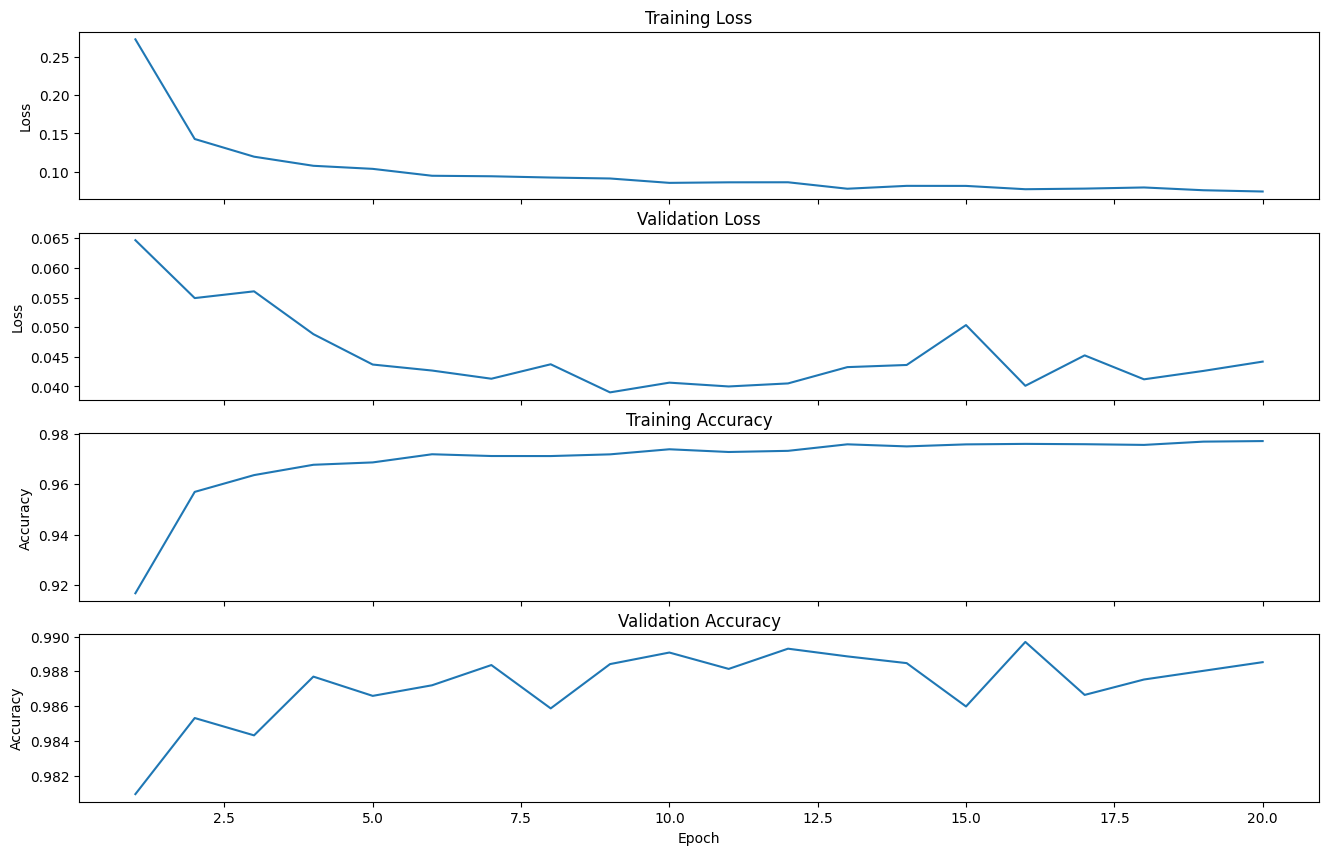

In [4]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # Initialiserer model lag
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 12, 12)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 20,
    optimizer = optim.Adam
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "adam_optimizer",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

Var Adam bedre end SGD? Har Adam bruge for så mange Epochs som SGD?

Prøv at træne modellen for 50 epochs. Brug ML-flow for at se om Adam overfitter datasættet. Det kan man se ved at kigge på hvordan træning loss og validering loss udvikler sig under træning.

## Opgave: En Sidste Model
Nu har du prøvet mange forskellige modeller. Prøv at træne en model med de parametere du tror vil virke bedste og træn det. Når du tror at du har trænet den bedste model, så køre test kodeblokken og se hvor god din model kan detekterer hånd skrevet nummer:

  2%|▏         | 1/50 [00:10<08:37, 10.55s/it, Train_loss=0.265, Val_loss=0.066, Train_acc=0.919, Val_acc=0.981, Time_Taken=10.495s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.9806072699262741 i 'saved_models/Final_model_best.pt'


  4%|▍         | 2/50 [00:20<08:12, 10.27s/it, Train_loss=0.135, Val_loss=0.050, Train_acc=0.960, Val_acc=0.985, Time_Taken=9.755s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.9849844860269669 i 'saved_models/Final_model_best.pt'


  6%|▌         | 3/50 [00:31<08:14, 10.51s/it, Train_loss=0.115, Val_loss=0.055, Train_acc=0.966, Val_acc=0.982, Time_Taken=10.757s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


  8%|▊         | 4/50 [00:41<08:04, 10.53s/it, Train_loss=0.104, Val_loss=0.046, Train_acc=0.968, Val_acc=0.988, Time_Taken=10.487s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.987533244680851 i 'saved_models/Final_model_best.pt'


 10%|█         | 5/50 [00:52<07:53, 10.52s/it, Train_loss=0.094, Val_loss=0.046, Train_acc=0.972, Val_acc=0.987, Time_Taken=10.446s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 12%|█▏        | 6/50 [01:03<07:49, 10.67s/it, Train_loss=0.094, Val_loss=0.051, Train_acc=0.971, Val_acc=0.986, Time_Taken=10.926s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 14%|█▍        | 7/50 [01:13<07:28, 10.42s/it, Train_loss=0.091, Val_loss=0.042, Train_acc=0.973, Val_acc=0.988, Time_Taken=9.823s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.9876994680851063 i 'saved_models/Final_model_best.pt'


 16%|█▌        | 8/50 [01:23<07:17, 10.41s/it, Train_loss=0.082, Val_loss=0.042, Train_acc=0.975, Val_acc=0.988, Time_Taken=10.317s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.9883643617021277 i 'saved_models/Final_model_best.pt'


 18%|█▊        | 9/50 [01:34<07:08, 10.46s/it, Train_loss=0.087, Val_loss=0.040, Train_acc=0.974, Val_acc=0.989, Time_Taken=10.489s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.9886968085106383 i 'saved_models/Final_model_best.pt'


 20%|██        | 10/50 [01:44<06:58, 10.46s/it, Train_loss=0.086, Val_loss=0.037, Train_acc=0.974, Val_acc=0.988, Time_Taken=10.405s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 22%|██▏       | 11/50 [01:55<06:48, 10.46s/it, Train_loss=0.080, Val_loss=0.035, Train_acc=0.976, Val_acc=0.991, Time_Taken=10.406s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.9910239361702128 i 'saved_models/Final_model_best.pt'


 24%|██▍       | 12/50 [02:04<06:28, 10.23s/it, Train_loss=0.080, Val_loss=0.040, Train_acc=0.977, Val_acc=0.988, Time_Taken=9.662s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 26%|██▌       | 13/50 [02:15<06:21, 10.32s/it, Train_loss=0.081, Val_loss=0.040, Train_acc=0.976, Val_acc=0.989, Time_Taken=10.451s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 28%|██▊       | 14/50 [02:25<06:13, 10.37s/it, Train_loss=0.075, Val_loss=0.043, Train_acc=0.977, Val_acc=0.988, Time_Taken=10.463s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 30%|███       | 15/50 [02:36<06:03, 10.39s/it, Train_loss=0.075, Val_loss=0.050, Train_acc=0.977, Val_acc=0.987, Time_Taken=10.363s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 32%|███▏      | 16/50 [02:47<05:56, 10.48s/it, Train_loss=0.074, Val_loss=0.038, Train_acc=0.977, Val_acc=0.990, Time_Taken=10.608s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 34%|███▍      | 17/50 [02:57<05:40, 10.33s/it, Train_loss=0.077, Val_loss=0.040, Train_acc=0.977, Val_acc=0.989, Time_Taken=9.925s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 36%|███▌      | 18/50 [03:07<05:31, 10.37s/it, Train_loss=0.072, Val_loss=0.039, Train_acc=0.978, Val_acc=0.990, Time_Taken=10.418s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 38%|███▊      | 19/50 [03:17<05:22, 10.39s/it, Train_loss=0.067, Val_loss=0.040, Train_acc=0.980, Val_acc=0.990, Time_Taken=10.402s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 40%|████      | 20/50 [03:28<05:12, 10.42s/it, Train_loss=0.067, Val_loss=0.046, Train_acc=0.980, Val_acc=0.989, Time_Taken=10.447s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 42%|████▏     | 21/50 [03:38<04:59, 10.34s/it, Train_loss=0.071, Val_loss=0.037, Train_acc=0.978, Val_acc=0.992, Time_Taken=10.041s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Gemt modellen med bedste accuracy 0.9918550531914894 i 'saved_models/Final_model_best.pt'


 44%|████▍     | 22/50 [03:48<04:47, 10.26s/it, Train_loss=0.068, Val_loss=0.038, Train_acc=0.979, Val_acc=0.989, Time_Taken=10.033s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 46%|████▌     | 23/50 [03:59<04:41, 10.42s/it, Train_loss=0.066, Val_loss=0.053, Train_acc=0.980, Val_acc=0.987, Time_Taken=10.735s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 48%|████▊     | 24/50 [04:09<04:31, 10.43s/it, Train_loss=0.072, Val_loss=0.038, Train_acc=0.979, Val_acc=0.989, Time_Taken=10.408s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 50%|█████     | 25/50 [04:20<04:21, 10.44s/it, Train_loss=0.065, Val_loss=0.040, Train_acc=0.980, Val_acc=0.990, Time_Taken=10.413s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 52%|█████▏    | 26/50 [04:30<04:07, 10.31s/it, Train_loss=0.066, Val_loss=0.040, Train_acc=0.980, Val_acc=0.990, Time_Taken=9.922s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 54%|█████▍    | 27/50 [04:40<03:56, 10.29s/it, Train_loss=0.066, Val_loss=0.042, Train_acc=0.980, Val_acc=0.989, Time_Taken=10.199s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 56%|█████▌    | 28/50 [04:51<03:47, 10.34s/it, Train_loss=0.065, Val_loss=0.032, Train_acc=0.980, Val_acc=0.992, Time_Taken=10.419s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 58%|█████▊    | 29/50 [05:01<03:38, 10.39s/it, Train_loss=0.067, Val_loss=0.040, Train_acc=0.979, Val_acc=0.991, Time_Taken=10.441s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 60%|██████    | 30/50 [05:12<03:28, 10.41s/it, Train_loss=0.070, Val_loss=0.040, Train_acc=0.980, Val_acc=0.990, Time_Taken=10.410s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 62%|██████▏   | 31/50 [05:21<03:13, 10.19s/it, Train_loss=0.065, Val_loss=0.038, Train_acc=0.980, Val_acc=0.989, Time_Taken=9.636s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 64%|██████▍   | 32/50 [05:32<03:05, 10.28s/it, Train_loss=0.066, Val_loss=0.039, Train_acc=0.981, Val_acc=0.991, Time_Taken=10.438s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 66%|██████▌   | 33/50 [05:42<02:55, 10.32s/it, Train_loss=0.065, Val_loss=0.042, Train_acc=0.980, Val_acc=0.987, Time_Taken=10.362s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 68%|██████▊   | 34/50 [05:53<02:45, 10.37s/it, Train_loss=0.064, Val_loss=0.041, Train_acc=0.980, Val_acc=0.990, Time_Taken=10.422s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 70%|███████   | 35/50 [06:03<02:35, 10.34s/it, Train_loss=0.071, Val_loss=0.036, Train_acc=0.979, Val_acc=0.990, Time_Taken=10.195s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 72%|███████▏  | 36/50 [06:13<02:23, 10.25s/it, Train_loss=0.065, Val_loss=0.038, Train_acc=0.980, Val_acc=0.991, Time_Taken=9.992s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 74%|███████▍  | 37/50 [06:23<02:14, 10.35s/it, Train_loss=0.066, Val_loss=0.036, Train_acc=0.981, Val_acc=0.991, Time_Taken=10.521s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 76%|███████▌  | 38/50 [06:34<02:05, 10.43s/it, Train_loss=0.065, Val_loss=0.041, Train_acc=0.981, Val_acc=0.989, Time_Taken=10.578s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 78%|███████▊  | 39/50 [06:45<01:55, 10.46s/it, Train_loss=0.060, Val_loss=0.047, Train_acc=0.982, Val_acc=0.989, Time_Taken=10.467s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 80%|████████  | 40/50 [06:55<01:43, 10.36s/it, Train_loss=0.063, Val_loss=0.042, Train_acc=0.981, Val_acc=0.989, Time_Taken=10.054s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 82%|████████▏ | 41/50 [07:05<01:32, 10.30s/it, Train_loss=0.069, Val_loss=0.041, Train_acc=0.981, Val_acc=0.991, Time_Taken=10.098s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 84%|████████▍ | 42/50 [07:15<01:22, 10.35s/it, Train_loss=0.065, Val_loss=0.043, Train_acc=0.981, Val_acc=0.990, Time_Taken=10.408s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 86%|████████▌ | 43/50 [07:26<01:12, 10.38s/it, Train_loss=0.059, Val_loss=0.048, Train_acc=0.983, Val_acc=0.989, Time_Taken=10.414s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 88%|████████▊ | 44/50 [07:36<01:02, 10.42s/it, Train_loss=0.062, Val_loss=0.046, Train_acc=0.981, Val_acc=0.989, Time_Taken=10.470s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 90%|█████████ | 45/50 [07:46<00:51, 10.33s/it, Train_loss=0.067, Val_loss=0.046, Train_acc=0.980, Val_acc=0.988, Time_Taken=9.828s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 92%|█████████▏| 46/50 [07:57<00:41, 10.32s/it, Train_loss=0.062, Val_loss=0.042, Train_acc=0.981, Val_acc=0.989, Time_Taken=10.255s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 94%|█████████▍| 47/50 [08:07<00:31, 10.35s/it, Train_loss=0.062, Val_loss=0.042, Train_acc=0.982, Val_acc=0.991, Time_Taken=10.381s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 96%|█████████▌| 48/50 [08:18<00:20, 10.39s/it, Train_loss=0.063, Val_loss=0.042, Train_acc=0.982, Val_acc=0.990, Time_Taken=10.428s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


 98%|█████████▊| 49/50 [08:28<00:10, 10.43s/it, Train_loss=0.062, Val_loss=0.041, Train_acc=0.982, Val_acc=0.990, Time_Taken=10.429s]

Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'


100%|██████████| 50/50 [08:38<00:00, 10.37s/it, Train_loss=0.062, Val_loss=0.039, Train_acc=0.982, Val_acc=0.992, Time_Taken=9.651s]


Gemt modellen fra sidste checkpoint i 'saved_models/Final_model.pt'
Træning er færdigt. Træning tog 515.0903368539985s og average epoch tid var 10.30180673707997


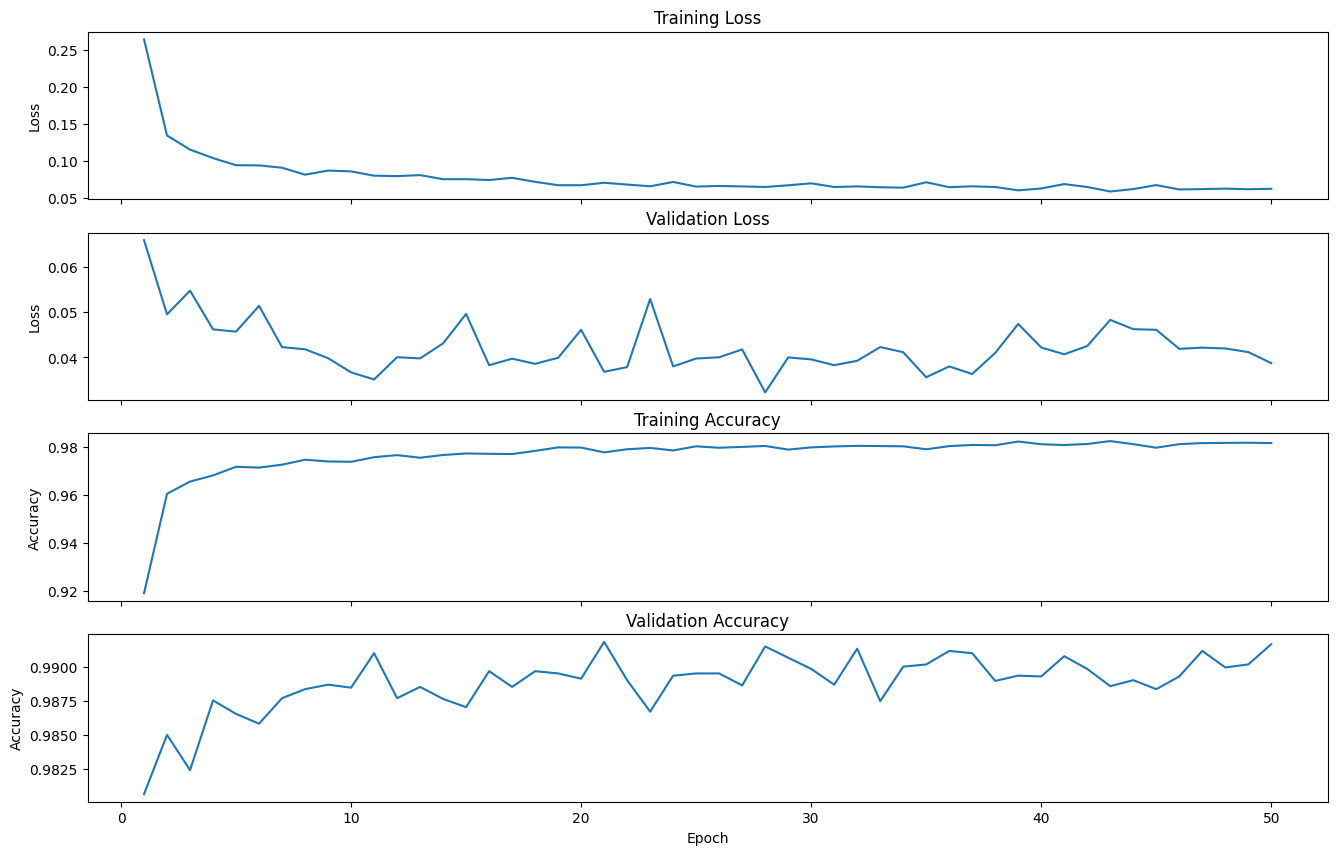

In [7]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder

    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch

    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, name, hyperparameters: dict = {}, input_channels = 1, num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()

        # Navngiv model
        self.name = name

        # Load Hyperparametre
        self.hyperparameters = hyperparameters

        # Vælg loss function
        self.criterion = nn.CrossEntropyLoss()
        setattr(self.hyperparameters, 'loss', self.criterion.__class__.__name__)

        # NOTE: Initialiserer model lag (Husk at slette raise linjen når du færdig)
        #raise NotImplementedError("Implementer Netværksarkitektur.")
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, 12, 12)
        self.conv4 = nn.Conv2d(128, num_classes, 1, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket

        Args:
        x (torch.Tensor): Input tensor

        Returns:
        torch.Tensor: Output tensor
        """
        # NOTE: Implementere forward pass (Husk at slette raise linjen når du færdig)
        #raise NotImplementedError("Implementer forward pass")
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = x.mean(dim=(2,3))
        output = F.log_softmax(x, dim=1)
        return output

# Sæt valgmuligheder
hyperparameters = Hyperparameters(
    lr = 0.005,
    epochs = 50,
    optimizer = optim.Adam,
)

# Hent model architecturene fra model_architecture.py
model = Net(
    name = "Final_model",
    hyperparameters=hyperparameters,
    input_channels=input_shape[0],
    num_classes=num_classes
).to(device)

# tilføj optimizer til model
model.optimizer = model.hyperparameters.optimizer(
    model.parameters(),
    lr=model.hyperparameters.lr,
    #momentum=model.hyperparameters.momentum,
)
setattr(model.hyperparameters, 'optimizer', model.optimizer.__class__.__name__)

logs = train(train_loader, val_loader, model)

Fig, ax = plot_training_logs(logs)
Fig.show()

## VENT!
Husk at man burde kun bruge test datasætet en gang til sidste. Er du sikker at din nuværende model er den du vil gerne teste på?

In [9]:
model_path = "saved_models/Final_model_best.pth"
model = torch.jit.load(model_path, map_location=device)
test(test_loader, model)

Test accuracy: 0.9890525341033936


Hvor meget bedre er denne model end den initial model i Eksemple_CNN.ipynb?